# Imports

In [1]:
import sys
import math
import statistics
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import *
from decimal import Decimal
from IPython.display import Image
from matplotlib import pyplot as plt

sys.path.insert(0, '/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm')
from viz_preprocess import *
from viz_sequence import *

plt.style.use('default')
pd.set_option('display.max_columns', None)

# Quick Links

<ol>
    <li><a href=#find_motif>Motif Discovery</a></li>
    <li><a href=#score_dist>Score Distribution</a></li>
    <li><a href=#sig_snps>Significant SNPs</a></li>
    <li><a href=#neg_snps>Negative Scoring SNPs</a></li>
    <li><a href=#pos_snps>Positive Scoring SNPs</a></li>
    <li><a href=#final_table>Final SNP Table</a></li>
</ol>

## Choose Cluster

In [2]:
cluster_input = 20

# Prepare Scores

In [3]:
cluster = str(cluster_input)
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster' \
                +cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print()
print("Num effect sequences:", '\t', '\t', len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster' \
                    +cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster' \
                    +cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", '\t', len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster' \
                        +cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

print("Num scores:", '\t', '\t', '\t', len(noneffect_onehot))

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) \
                           for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'
                                         +cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) \
                             for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'
                                           +cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)


Num effect sequences: 	 	 608
Num noneffect sequences: 	 608
Num scores: 	 	 	 608


# Model the Distribution of Importance Scores <a name='find_motif' />

In [4]:
sig_list = []
ksvals = []
motifs = []

for seq in range(len(effect_onehot)):
    if merged_ism_scores[seq] >= 0:
        scores = [np.sum(j) for j in merged_effect_scores[seq][400:600]]
    else:
        scores = [np.sum(j) for j in merged_noneffect_scores[seq][400:600]]
    shape, mean, stdev = t.fit(scores)
    kstat, kval = stats.kstest(scores, 't', args=[shape, mean, stdev])
    if merged_ism_scores[seq] >= 0:
        pvals = t.cdf([np.sum(j) for j in merged_effect_scores[seq]], shape, mean, stdev)
    else:
        pvals = t.cdf([np.sum(j) for j in merged_noneffect_scores[seq]], shape, mean, stdev)
    ksvals.append([kstat, kval])
    
    start = 499
    end = 499
    while True:
        if pvals[start - 1] <= 0.95:
            if pvals[start - 2] <= 0.95:
                break
            else:
                start -= 1
        else:
            start -= 1
    while True:
        if pvals[end] <= 0.95:
            if pvals[end + 1] <= 0.95:
                break
            else:
                end += 1
        else:
            end += 1

    if merged_ism_scores[seq] >= 0:
        if start != end:
            motif = effect_seqs[seq][start:end]
            motif_len = len(motif)
            if motif_len < 7:
                mstart = start - math.floor((10 - motif_len) / 2)
                mend = end + math.ceil((10 - motif_len) / 2)
                motif = effect_seqs[seq][mstart:mend]
            else:
                mstart = start
                mend = end
        else:
            mstart = start - 4
            mend = end + 6
            motif = effect_seqs[seq][mstart:mend]
    else:
        if start != end:
            motif = noneffect_seqs[seq][start:end]
            motif_len = len(motif)
            if motif_len < 7:
                mstart = start - math.floor((10 - motif_len) / 2)
                mend = end + math.ceil((10 - motif_len) / 2)
                motif = noneffect_seqs[seq][mstart:mend]
            else:
                mstart = start
                mend = end
                
        else:
            mstart = start - 4
            mend = end + 6
            motif = noneffect_seqs[seq][mstart:mend]
    
    motifs.append(motif)
    sig_list.append([start, end, shape, mean, stdev, mstart, mend])

sig_list_stats = [x[1]-x[0] for x in sig_list if x[1]-x[0] != 0]
all_list_stats = [len(x) for x in motifs]
ksvals_pvals = [x[1] for x in ksvals]
sig_ksvals = [x for x in ksvals_pvals if x < 0.01]
print()
print('Mean KS-test p-value:', '\t', '\t', statistics.mean(ksvals_pvals))
print('Median KS-test p-value:', '\t', statistics.median(ksvals_pvals))
print('St. Dev KS-test p-value:', '\t', statistics.stdev(ksvals_pvals))
print('Max KS-test p-value:', '\t', '\t', max(ksvals_pvals))
print('Min KS-test p-value:', '\t', '\t', min(ksvals_pvals))
print('Num significant p-values:', '\t', len(sig_ksvals))
print()
print('Mean non-zero motif length:', '\t', statistics.mean(sig_list_stats))
print('Median non-zero motif length:', '\t', statistics.median(sig_list_stats))
print('St. Dev non-zero motif length:', '\t', statistics.stdev(sig_list_stats))
#print('Mode non-zero motif length:', '\t', statistics.mode(sig_list_stats))
print('Max non-zero motif length:', '\t', max(sig_list_stats))
print('Min non-zero motif lenght:', '\t', min(sig_list_stats))
print()
print('Mean motif length:', '\t', '\t', statistics.mean(all_list_stats))
print('Median motif length:', '\t', '\t', statistics.median(all_list_stats))
print('St. Dev motif length:', '\t', '\t', statistics.stdev(all_list_stats))
#print('Mode motif length:', '\t', '\t', statistics.mode(all_list_stats))
print('Max motif length:', '\t', '\t', max(all_list_stats))
print('Min motif lenght:', '\t', '\t', min(all_list_stats))


Mean KS-test p-value: 	 	 0.4713560217181517
Median KS-test p-value: 	 0.46653903598228985
St. Dev KS-test p-value: 	 0.32179228914929847
Max KS-test p-value: 	 	 0.9989276972432048
Min KS-test p-value: 	 	 1.786648443055622e-07
Num significant p-values: 	 33

Mean non-zero motif length: 	 8.784982935153584
Median non-zero motif length: 	 9
St. Dev non-zero motif length: 	 5.998131536957096
Max non-zero motif length: 	 27
Min non-zero motif lenght: 	 1

Mean motif length: 	 	 10.774671052631579
Median motif length: 	 	 10.0
St. Dev motif length: 	 	 2.6948391503901177
Max motif length: 	 	 27
Min motif lenght: 	 	 7


# Prepare DataFrame

In [5]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'
                   +cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                        +'snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                        +'snps_final/ld_buddies_table_stage3.tsv', sep='\t')

effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
orig_score = []
diff_score = []
ratio_score = []
ism_score = []
delta_score = []
idr_peak = []
gwas = []
gwas_pval = []
coloc = []

for index,row in snps.iterrows():
    
    orig_eff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_effect_scores[index][475:525]]))
    eff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_effect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    eff_cent_nonzero = np.sum(np.array([max(0, np.sum(j)) \
                                        for j in \
                                        merged_effect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    effect_center.append(eff_cent)
    
    orig_noneff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_noneffect_scores[index][475:525]]))
    noneff_cent = np.sum(np.array([np.sum(j) \
                                   for j in \
                                   merged_noneffect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    noneff_cent_nonzero = np.sum(np.array([max(0, np.sum(j)) \
                                           for j in \
                                           merged_noneffect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    noneffect_center.append(noneff_cent)
    
    eff_bg = np.sum(np.array([max(0, np.sum(j)) \
                              for j in merged_effect_scores[index][400:600]]))
    eff_rat = eff_cent_nonzero / eff_bg
    effect_ratio.append(eff_rat)
    
    noneff_bg = np.sum(np.array([max(0, np.sum(j)) \
                                 for j in merged_noneffect_scores[index][400:600]]))
    noneff_rat = noneff_cent_nonzero / noneff_bg
    noneffect_ratio.append(noneff_rat)
    
    orig_score.append(orig_eff_cent - orig_noneff_cent)
    if (sig_list[index][1] - sig_list[index][0]) > 0:
        diff_score.append(eff_cent_nonzero - noneff_cent_nonzero)
        ratio_score.append(eff_rat - noneff_rat)
    else:
        diff_score.append('NAN')
        ratio_score.append('NAN')
    
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    lowest_pval = 1
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        if rw['has_coloc'] == True:
            has_coloc = True
        if rw['pvalue'] < lowest_pval:
            gwas_list = rw['source_gwas']
            lowest_pval = rw['pvalue']
    gwas.append(gwas_list)
    gwas_pval.append(lowest_pval)
    coloc.append(has_coloc)

snps.effect.replace('NAN', 'Z', inplace=True)
snps.noneffect.replace('NAN', 'Z', inplace=True)
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['orig_score'] = orig_score
snps['diff_score'] = diff_score
snps['ratio_score'] = ratio_score
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['gwas'] = gwas
snps['gwas_pval'] = gwas_pval
snps['coloc'] = coloc
snps['idr_peak'] = idr_peak
snps['motif'] = motifs
snps.drop(['source_gwas','pvalue','ld_tag_chr','ld_tag_pos','r2_with_ld_tag'], axis=1, inplace=True)
snps.sort_values(by=['rsid', 'effect'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)
snps.effect.replace('Z', 'NAN', inplace=True)
snps.noneffect.replace('Z', 'NAN', inplace=True)
print()
print('Number of Unique SNPs:', len(snps))

/users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Number of Unique SNPs: 540


## Distribution of Original gkmExplain Scores <a name='score_dist' />


Number of SNPs with significant motifs: 540


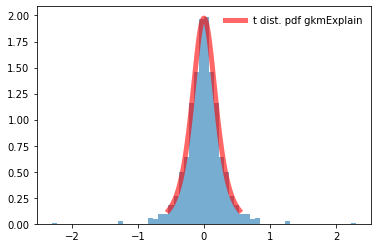

In [6]:
true_orig_scores = snps.orig_score.tolist()
true_orig_scores = [i for i in true_orig_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_orig_scores))
oppo_orig_scores = [-1 * i for i in true_orig_scores]
orig_scores = true_orig_scores + oppo_orig_scores
orig_shape, orig_mean, orig_stdev = t.fit(orig_scores)
fig, ax = plt.subplots(1, 1)
orig_x = np.linspace(t.ppf(0.025, orig_shape, orig_mean, orig_stdev),
                t.ppf(0.975, orig_shape, orig_mean, orig_stdev), 1000)
ax.plot(orig_x, t.pdf(orig_x, orig_shape, orig_mean, orig_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(orig_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for Original gkmExplain Scores

In [7]:
print()
print('Shape:', '\t', orig_shape)
print('Mean:', '\t', orig_mean)
print('Stdev:', '\t', orig_stdev)
print()
print(stats.kstest(orig_scores, 't', args=[orig_shape, orig_mean, orig_stdev]))


Shape: 	 3.7505323468247003
Mean: 	 9.325807657227217e-08
Stdev: 	 0.1891663844947924

KstestResult(statistic=0.009666760996227208, pvalue=0.9999612608099256)


## Distribution of Non-Zero Difference gkmExplain Scores


Number of SNPs with significant motifs: 254


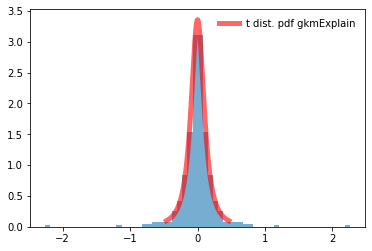

In [8]:
true_diff_scores = snps.diff_score.tolist()
true_diff_scores = [i for i in true_diff_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_diff_scores))
oppo_diff_scores = [-1 * i for i in true_diff_scores]
diff_scores = true_diff_scores + oppo_diff_scores
diff_shape, diff_mean, diff_stdev = t.fit(diff_scores)
fig, ax = plt.subplots(1, 1)
diff_x = np.linspace(t.ppf(0.025, diff_shape, diff_mean, diff_stdev),
                t.ppf(0.975, diff_shape, diff_mean, diff_stdev), 1000)
ax.plot(diff_x, t.pdf(diff_x, diff_shape, diff_mean, diff_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(diff_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## KS-test for Non-Zero Difference gkmExplain Scores

In [9]:
print()
print('Shape:', '\t', diff_shape)
print('Mean:', '\t', diff_mean)
print('Stdev:', '\t', diff_stdev)
print()
print(stats.kstest(diff_scores, 't', args=[diff_shape, diff_mean, diff_stdev]))


Shape: 	 1.9483697310678343
Mean: 	 -9.846804706730479e-07
Stdev: 	 0.10494553462572767

KstestResult(statistic=0.01878522399059873, pvalue=0.9939251360192939)


## Distribution of Ratio Difference gkmExplain Scores


Number of SNPs with significant motifs: 254


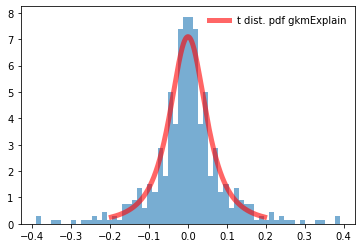

In [10]:
true_ratio_scores = snps.ratio_score.tolist()
true_ratio_scores = [i for i in true_ratio_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_ratio_scores))
oppo_ratio_scores = [-1 * i for i in true_ratio_scores]
ratio_scores = true_ratio_scores + oppo_ratio_scores
ratio_shape, ratio_mean, ratio_stdev = t.fit(ratio_scores)
fig, ax = plt.subplots(1, 1)
ratio_x = np.linspace(t.ppf(0.025, ratio_shape, ratio_mean, ratio_stdev),
                t.ppf(0.975, ratio_shape, ratio_mean, ratio_stdev), 1000)
ax.plot(ratio_x, t.pdf(ratio_x, ratio_shape, ratio_mean, ratio_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(ratio_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## KS-test for Ratio Difference gkmExplain Scores

In [11]:
print()
print('Shape:', '\t', ratio_shape)
print('Mean:', '\t', ratio_mean)
print('Stdev:', '\t', ratio_stdev)
print()
print(stats.kstest(ratio_scores, 't', args=[ratio_shape, ratio_mean, ratio_stdev]))


Shape: 	 2.228685992925799
Mean: 	 3.532749673072866e-08
Stdev: 	 0.05042599644638328

KstestResult(statistic=0.028801968825964086, pvalue=0.7933074694612129)


## Distribution of ISM Scores

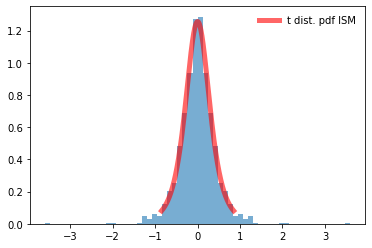

In [12]:
true_ism_scores = snps.ism_score.tolist()
oppo_ism_scores = [-1 * i for i in true_ism_scores]
ism_scores = true_ism_scores + oppo_ism_scores
ism_shape, ism_mean, ism_stdev = t.fit(ism_scores)
fig, ax = plt.subplots(1, 1)
ism_x = np.linspace(t.ppf(0.025, ism_shape, ism_mean, ism_stdev),
                t.ppf(0.975, ism_shape, ism_mean, ism_stdev), 1000)
ax.plot(ism_x, t.pdf(ism_x, ism_shape, ism_mean, ism_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf ISM')
ax.hist(ism_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for ISM Scores

In [13]:
print()
print('Shape:', '\t', ism_shape)
print('Mean:', '\t', ism_mean)
print('Stdev:', '\t', ism_stdev)
print()
print(stats.kstest(ism_scores, 't', args=[ism_shape, ism_mean, ism_stdev]))


Shape: 	 3.7313813064554893
Mean: 	 -1.0691392505434764e-06
Stdev: 	 0.29730663145824293

KstestResult(statistic=0.008953334915434069, pvalue=0.9999944833453233)


## Distribution of Delta Scores

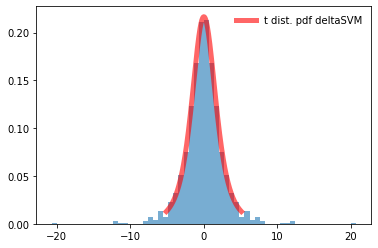

In [14]:
true_delta_scores = snps.delta_score.tolist()
oppo_delta_scores = [-1 * i for i in true_delta_scores]
delta_scores = true_delta_scores + oppo_delta_scores
delta_shape, delta_mean, delta_stdev = t.fit(delta_scores)
fig, ax = plt.subplots(1, 1)
delta_x = np.linspace(t.ppf(0.025, delta_shape, delta_mean, delta_stdev),
                t.ppf(0.975, delta_shape, delta_mean, delta_stdev), 1000)
ax.plot(delta_x, t.pdf(delta_x, delta_shape, delta_mean, delta_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf deltaSVM')
ax.hist(delta_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for Delta Scores

In [15]:
print()
print('Shape:', '\t', delta_shape)
print('Mean:', '\t', delta_mean)
print('Stdev:', '\t', delta_stdev)
print()
print(stats.kstest(delta_scores, 't', args=[delta_shape, delta_mean, delta_stdev]))


Shape: 	 3.4048254852072817
Mean: 	 5.6524862467254295e-06
Stdev: 	 1.7137036608590148

KstestResult(statistic=0.009535573261928554, pvalue=0.9999720100659752)


# Get Significant SNPs

In [16]:
pd.set_option('mode.chained_assignment', None)

snps.orig_score.replace('NAN', 0.0, inplace=True)
snps.diff_score.replace('NAN', 0.0, inplace=True)
snps.ratio_score.replace('NAN', 0.0, inplace=True)

orig_pval = [2 * min(t.cdf(x, orig_shape, orig_mean, orig_stdev),
                        1 - t.cdf(x, orig_shape, orig_mean, orig_stdev)) \
                for x in snps['orig_score']]

diff_pval = [2 * min(t.cdf(x, diff_shape, diff_mean, diff_stdev),
                        1 - t.cdf(x, diff_shape, diff_mean, diff_stdev)) \
                for x in snps['diff_score']]

ratio_pval = [2 * min(t.cdf(x, ratio_shape, ratio_mean, ratio_stdev),
                        1 - t.cdf(x, ratio_shape, ratio_mean, ratio_stdev)) \
                for x in snps['ratio_score']]

ism_pval = [2 * min(t.cdf(x, ism_shape, ism_mean, ism_stdev),
                1 - t.cdf(x, ism_shape, ism_mean, ism_stdev)) \
            for x in snps['ism_score']]

delta_pval = [2 * min(t.cdf(x, delta_shape, delta_mean, delta_stdev),
                1 - t.cdf(x, delta_shape, delta_mean, delta_stdev)) \
            for x in snps['delta_score']]

kstest_pval = [ksvals_pvals[x] for x in snps.index]

snps['orig_pval'] = orig_pval
snps['diff_pval'] = diff_pval
snps['ratio_pval'] = ratio_pval
snps['ism_pval'] = ism_pval
snps['delta_pval'] = delta_pval
snps['kstest_pval'] = kstest_pval

neg_orig_cutoff = t.ppf(0.025, orig_shape, orig_mean, orig_stdev)
neg_diff_cutoff = t.ppf(0.025, diff_shape, diff_mean, diff_stdev)
neg_ratio_cutoff_low = t.ppf(0.1, ratio_shape, ratio_mean, ratio_stdev)
neg_ratio_cutoff_high = t.ppf(0.025, ratio_shape, ratio_mean, ratio_stdev)
neg_ism_cutoff = t.ppf(0.025, ism_shape, ism_mean, ism_stdev)
neg_delta_cutoff = t.ppf(0.025, delta_shape, delta_mean, delta_stdev)

snps.sort_values(by=['ratio_pval'], ascending=True, inplace=True)
neg_snps = snps.loc[(snps['orig_score'] < neg_orig_cutoff)
                    & (snps['ism_score'] < neg_ism_cutoff)
                    & (snps['delta_score'] < neg_delta_cutoff)]

pos_orig_cutoff = t.ppf(0.975, orig_shape, orig_mean, orig_stdev)
pos_diff_cutoff = t.ppf(0.975, diff_shape, diff_mean, diff_stdev)
pos_ratio_cutoff_low = t.ppf(0.9, ratio_shape, ratio_mean, ratio_stdev)
pos_ratio_cutoff_high = t.ppf(0.975, ratio_shape, ratio_mean, ratio_stdev)
pos_ism_cutoff = t.ppf(0.975, ism_shape, ism_mean, ism_stdev)
pos_delta_cutoff = t.ppf(0.975, delta_shape, delta_mean, delta_stdev)

pos_snps = snps.loc[(snps['orig_score'] > pos_orig_cutoff)
                    & (snps['ism_score'] > pos_ism_cutoff)
                    & (snps['delta_score'] > pos_delta_cutoff)]

neg_confidence = [0 for x in range(len(neg_snps))]
pos_confidence = [0 for x in range(len(pos_snps))]

counter = 0
for index, row in neg_snps.iterrows():
    if (row['ratio_score'] < neg_ratio_cutoff_high):
        neg_confidence[counter] = 2
    elif (row['ratio_score'] < neg_ratio_cutoff_low) or (row['diff_score'] < neg_diff_cutoff):
        neg_confidence[counter] = 1
    counter += 1
    
counter = 0
for index, row in pos_snps.iterrows():
    if (row['ratio_score'] > pos_ratio_cutoff_high):
        pos_confidence[counter] = 2
    elif (row['ratio_score'] > pos_ratio_cutoff_low) or (row['diff_score'] > pos_diff_cutoff):
        pos_confidence[counter] = 1
    counter += 1
    
neg_snps['confidence'] = neg_confidence
pos_snps['confidence'] = pos_confidence

# Display Significant SNPs <a name='sig_snps' />

In [17]:
print()
print('Negative Original gkmExplain Cutoff:', '\t', '\t', '\t', neg_orig_cutoff)
print('Negative Non-Zero Difference gkmExplain Cutoff:', '\t', neg_diff_cutoff)
print('Negative Ratio Difference gkmExplain Low Cutoff:', '\t', neg_ratio_cutoff_low)
print('Negative Ratio Difference gkmExplain High Cutoff:', '\t', neg_ratio_cutoff_high)
print('Negative ISM Cutoff:', '\t', '\t', '\t', '\t', '\t', neg_ism_cutoff)
print('Negative deltaSVM Cutoff:', '\t', '\t', '\t', '\t', neg_delta_cutoff)
print()
print('Total SNPs with Negative Scores:', '\t', '\t', '\t', len(neg_snps))
print('Confident SNPs with Negative Scores:', '\t', '\t', '\t', len([i for i in neg_confidence if i > 0]))
print('Highly Confident SNPs with Negative Scores:', '\t', '\t', len([i for i in neg_confidence if i > 1]))
display(neg_snps)

print()
print('Positive Original gkmExplain Cutoff:', '\t', '\t', '\t', pos_orig_cutoff)
print('Positive Non-Zero Difference gkmExplain Cutoff:', '\t', pos_diff_cutoff)
print('Positive Ratio Difference gkmExplain Low Cutoff:', '\t', pos_ratio_cutoff_low)
print('Positive Ratio Difference gkmExplain High Cutoff:', '\t', pos_ratio_cutoff_high)
print('Positive ISM Cutoff:', '\t', '\t', '\t', '\t', '\t', pos_ism_cutoff)
print('Positive deltaSVM Cutoff:', '\t', '\t', '\t', '\t', pos_delta_cutoff)
print()
print('Total SNPs with Positive Scores:', '\t', '\t', '\t', len(pos_snps))
print('Confident SNPs with Positive Scores:', '\t', '\t', '\t', len([i for i in pos_confidence if i > 0]))
print('Highly Confident SNPs with Positive Scores:', '\t', '\t', len([i for i in pos_confidence if i > 1]))
display(pos_snps)


Negative Original gkmExplain Cutoff: 	 	 	 -0.5392785451935634
Negative Non-Zero Difference gkmExplain Cutoff: 	 -0.4632077496353261
Negative Ratio Difference gkmExplain Low Cutoff: 	 -0.0909322690964616
Negative Ratio Difference gkmExplain High Cutoff: 	 -0.19696744251911602
Negative ISM Cutoff: 	 	 	 	 	 -0.8494287047843385
Negative deltaSVM Cutoff: 	 	 	 	 -5.1046635052440985

Total SNPs with Negative Scores: 	 	 	 12
Confident SNPs with Negative Scores: 	 	 	 9
Highly Confident SNPs with Negative Scores: 	 	 2


,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,effect_center,noneffect_center,effect_ratio,noneffect_ratio,orig_score,diff_score,ratio_score,ism_score,delta_score,gwas,gwas_pval,coloc,idr_peak,motif,orig_pval,diff_pval,ratio_pval,ism_pval,delta_pval,kstest_pval,confidence
456,chr2,127128581,127128582,rs13025717,T,C,C,T,C,T,+,77,0.170833,0.728387,0.127029,0.370106,-0.591625,-0.557554,-0.243077,-0.922462,-5.194540,Alzheimers_Jansen_2018,9.125833e-17,False,True,GCCCCGCCCA,0.038512,0.035579,0.032513,0.039676,0.047755,0.464950,2
570,chr6,27772520,27772521,rs760587,C,A,C,A,C,A,-,110,0.435097,1.124147,0.242959,0.454562,-0.686147,-0.689050,-0.211603,-1.078019,-6.154930,Nalls_23andMe,6.436710e-06,False,True,GCAGCAAACAAAGGCT,0.024799,0.023943,0.043252,0.025043,0.030036,0.297093,2
117,chr17,4901871,4901872,rs79436576,T,C,C,T,C,T,+,55,0.181571,0.956221,0.064499,0.253755,-0.794048,-0.761307,-0.189256,-1.243382,-7.323257,Alzheimers_Lambert_2013,4.789000e-05,True,False,TGGCCCCGCCCC,0.015698,0.019828,0.054161,0.016053,0.018162,0.003128,1
169,chr17,45848599,45848600,rs62054817,G,A,G,A,G,A,+,54,0.709528,1.521593,0.526604,0.714997,-0.772434,-0.812064,-0.188393,-1.217166,-7.004623,23andme_PD_hg38,1.136600e-22,True,True,CCAGTAGAGGGC,0.017142,0.017540,0.054657,0.017177,0.020707,0.135377,1
421,chr19,45326535,45326536,rs344791,C,G,G,C,C,G,-,71,0.013480,0.350969,0.212067,0.380288,-0.765767,-0.227150,-0.168221,-1.218823,-7.054930,Alzheimers_Jansen_2018,1.215671e-04,True,True,GCCTCCACTGT,0.017620,0.166214,0.068295,0.017103,0.020276,0.780367,1
481,chr3,49007333,49007334,rs6781790,T,C,C,T,T,C,+,92,0.457634,0.989116,0.204807,0.347743,-0.614162,-0.531481,-0.142937,-0.967614,-5.586559,Chang_23andMe_Parkinsons,2.349340e-03,False,True,GAGGGCGCTGTT,0.034551,0.038874,0.093037,0.034561,0.039287,0.179812,1
51,chr11,86103987,86103988,rs1237999,A,G,G,A,A,G,+,16,0.081320,0.540350,0.069093,0.189802,-0.657209,-0.374171,-0.120710,-1.024176,-5.881407,Alzheimers_Jansen_2018,7.143148e-16,False,True,GAGTCACCAACA,0.028260,0.073199,0.126076,0.029225,0.034108,0.146665,1
334,chr17,78426790,78426791,rs72914885,C,A,A,C,A,C,-,62,0.131646,0.540508,0.094641,0.211812,-0.584621,-0.346684,-0.117171,-0.904691,-5.354288,Nalls_23andMe,4.467170e-02,False,True,ACTGCCAGAGC,0.039851,0.083585,0.132735,0.041934,0.044058,0.019545,1
356,chr19,18462023,18462024,rs8103622,T,C,C,T,C,T,+,69,1.656516,2.282045,0.583448,0.656815,-0.637198,-0.625529,-0.073367,-1.047590,-5.974253,Alzheimers_Kunkle_2019,1.279000e-05,True,True,AGAGCGCCACCTGCTG,0.030996,0.028714,0.270696,0.027310,0.032653,0.883147,1
324,chr17,75032747,75032748,rs7218004,A,G,G,A,G,A,+,61,-0.126059,0.067793,0.000000,0.033609,-0.800234,-0.067793,-0.033609,-1.250016,-7.183489,Alzheimers_Kunkle_2019,8.541000e-06,True,True,CGGGCGGGTT,0.015312,0.586047,0.567455,0.015783,0.019227,0.082971,0



Positive Original gkmExplain Cutoff: 	 	 	 0.5392787317097164
Positive Non-Zero Difference gkmExplain Cutoff: 	 0.4632057802743845
Positive Ratio Difference gkmExplain Low Cutoff: 	 0.09093233975145511
Positive Ratio Difference gkmExplain High Cutoff: 	 0.19696751317410938
Positive ISM Cutoff: 	 	 	 	 	 0.8494265665058374
Positive deltaSVM Cutoff: 	 	 	 	 5.104674810216593

Total SNPs with Positive Scores: 	 	 	 14
Confident SNPs with Positive Scores: 	 	 	 7
Highly Confident SNPs with Positive Scores: 	 	 6


,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,effect_center,noneffect_center,effect_ratio,noneffect_ratio,orig_score,diff_score,ratio_score,ism_score,delta_score,gwas,gwas_pval,coloc,idr_peak,motif,orig_pval,diff_pval,ratio_pval,ism_pval,delta_pval,kstest_pval,confidence
177,chr17,45852666,45852667,rs62054825,G,A,G,A,G,A,+,54,0.803320,0.122708,0.658893,0.267734,0.711918,0.659803,0.391159,1.114556,6.367513,23andme_PD_hg38,1.247000e-22,True,False,CCCGGAAGTGGAGT,0.022141,0.025979,0.011806,0.022614,0.027280,0.329011,2
247,chr17,45947293,45947294,rs62062786,G,C,G,"A,C",G,"A,C",+,54,0.459236,-0.589524,0.349771,0.000000,1.295314,0.459236,0.349771,2.110986,12.069189,23andme_PD_hg38,4.529580e-22,True,True,CAGCTGCCACA,0.003001,0.050787,0.015033,0.002691,0.003835,0.954438,2
211,chr17,45896863,45896864,rs62056782,T,C,C,T,C,T,-,54,1.584398,0.392227,0.648440,0.314383,1.249746,1.192171,0.334057,1.951818,11.208082,23andme_PD_hg38,3.938570e-22,True,True,CGCCCTCTTGTG,0.003403,0.008405,0.016594,0.003541,0.004865,0.117361,2
32,chr11,60251676,60251677,rs636317,C,T,C,T,T,C,-,11,3.127441,0.870883,0.698854,0.400221,2.305392,2.256558,0.298633,3.585786,20.685852,Alzheimers_Kunkle_2019,5.906000e-15,False,False,TGCTGCCATCTGCTGG,0.000374,0.002444,0.021085,0.000400,0.000650,0.042034,2
232,chr17,45934729,45934730,rs62061716,G,A,A,G,A,G,-,54,1.113016,0.447204,0.487530,0.272546,0.641649,0.665812,0.214984,0.999494,5.690377,23andme_PD_hg38,4.036360e-22,True,False,CTCTAGGAGGCAGTA,0.030361,0.025540,0.041876,0.031422,0.037360,0.215565,2
314,chr17,46771150,46771151,rs199523,C,A,C,A,A,C,-,54,1.042165,0.289681,0.384568,0.170991,0.836726,0.700981,0.213577,1.328449,7.662085,23andme_PD_hg38,9.492900e-14,True,True,GCGCCACCTACAG,0.013259,0.023180,0.042441,0.012977,0.015870,0.817116,2
213,chr17,45897109,45897110,rs80346216,T,G,G,T,G,T,-,54,1.056080,0.492811,0.334152,0.196568,0.652107,0.563269,0.137584,1.018192,5.815028,23andme_PD_hg38,3.938720e-22,True,True,GCCGCTAGGGG,0.028929,0.034912,0.099808,0.029740,0.035197,0.208499,1
236,chr17,45935822,45935823,rs62061720,T,C,C,T,C,T,-,54,0.066836,-0.103392,0.041018,0.000000,0.579280,0.066836,0.041018,0.912748,5.251344,23andme_PD_hg38,4.036330e-22,True,False,CACTTTCTCC,0.040911,0.590884,0.493716,0.040892,0.046399,0.937936,0
428,chr2,95297493,95297494,rs2248415,G,C,C,"A,G,T",G,"C,A,T",+,85,0.027933,-0.066513,0.030120,0.000000,0.742305,0.027933,0.030120,1.191571,6.890723,Nalls_23andMe,7.828270e-03,False,True,GGGTGGGGGG,0.019437,0.815615,0.605394,0.018369,0.021724,0.034434,0
595,chr8,22604860,22604861,rs3735901,T,C,T,C,T,C,-,125,0.049692,-0.050830,0.028424,0.000000,0.759392,0.049692,0.028424,1.198163,7.846046,Chang_23andMe_Parkinsons,5.081120e-02,False,True,CCCCTGCCGC,0.018093,0.683584,0.624559,0.018052,0.014778,0.788997,0


# Visualize Top Negative Scoring SNPs <a name='neg_snps' />


Index: 456

RSID: rs13025717   ||    chr2 : 127128581 - 127128582   ||    Locus: 77   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 9.1258E-17   ||    Coloc: False   ||    Confidence: 2


Noneffect Allele: C   ||   Noneffect Center: 0.7284   ||   Center / 200bp : 0.3701

Noneffect Motif: GCCCCGCCCA


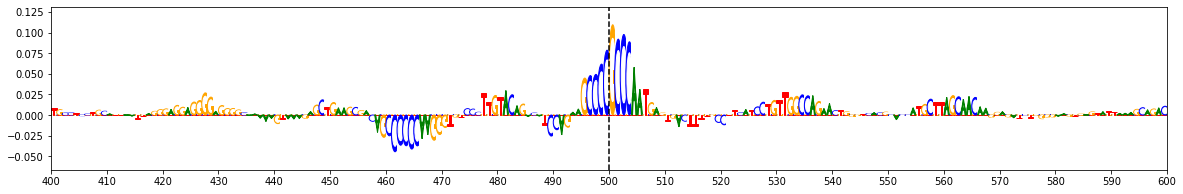

Effect Allele: T   ||   Effect Center: 0.1708   ||   Center / 200bp : 0.127

Effect Motif: GCCCCGCCCA


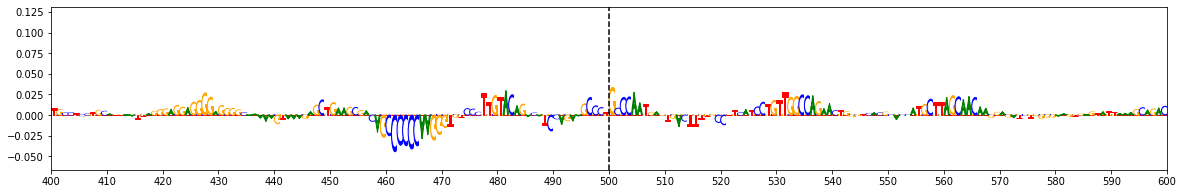

gkmExplain Score: -0.2431  ||  ISM Score: -0.9225  ||  deltaSVM Score: -5.1945

gkmExplain P-Value: 0.032513  ||  ISM P-Value: 0.039676  ||  deltaSVM P-Value: 0.047755

Difference Motif: GCCC(C/T)GCCCA


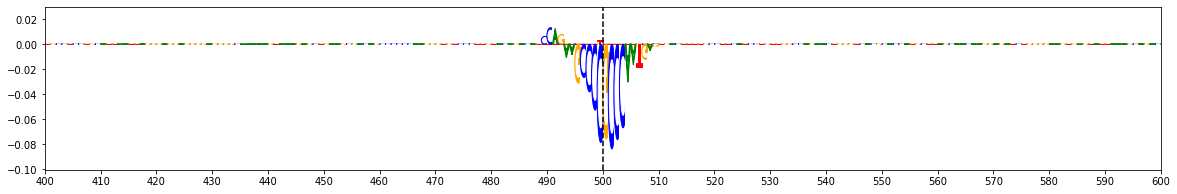



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 570

RSID: rs760587   ||    chr6 : 27772520 - 27772521   ||    Locus: 110   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 6.4367E-06   ||    Coloc: False   ||    Confidence: 2


Noneffect Allele: A   ||   Noneffect Center: 1.1241   ||   Center / 200bp : 0.4546

Noneffect Motif: GCAGCAAACAAAGGCT


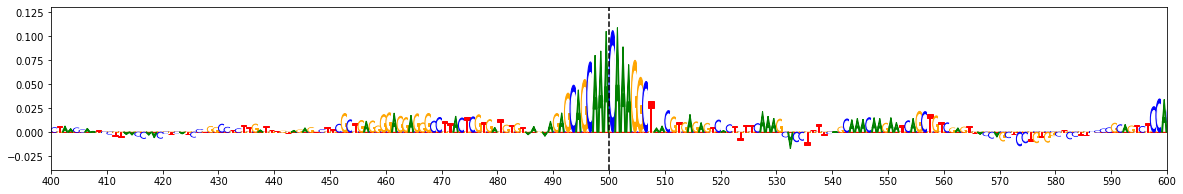

Effect Allele: C   ||   Effect Center: 0.4351   ||   Center / 200bp : 0.243

Effect Motif: GCAGCAAACAAAGGCT


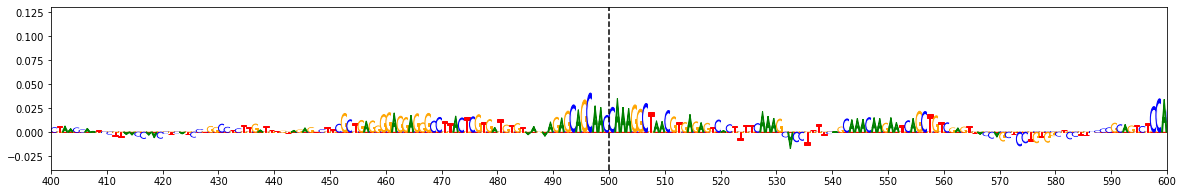

gkmExplain Score: -0.2116  ||  ISM Score: -1.078  ||  deltaSVM Score: -6.1549

gkmExplain P-Value: 0.043252  ||  ISM P-Value: 0.025043  ||  deltaSVM P-Value: 0.030036

Difference Motif: GCAGCAA(A/C)CAAAGGCT


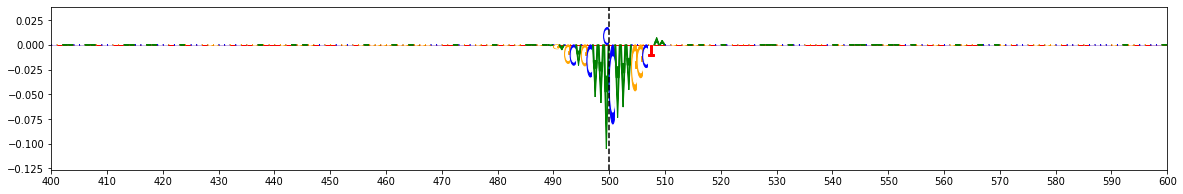



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 117

RSID: rs79436576   ||    chr17 : 4901871 - 4901872   ||    Locus: 55   ||    IDR Peak: False

GWAS: Alzheimers_Lambert_2013   ||    P-Value: 4.7890E-05   ||    Coloc: True   ||    Confidence: 1


Noneffect Allele: C   ||   Noneffect Center: 0.9562   ||   Center / 200bp : 0.2538

Noneffect Motif: TGGCCCCGCCCC


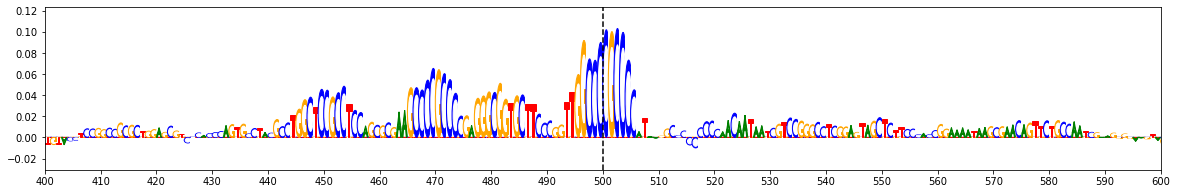

Effect Allele: T   ||   Effect Center: 0.1816   ||   Center / 200bp : 0.0645

Effect Motif: TGGCCCCGCCCC


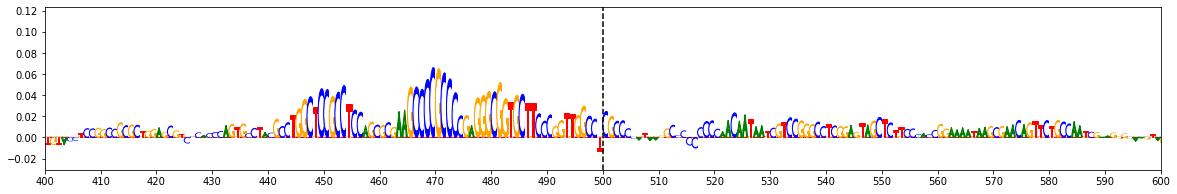

gkmExplain Score: -0.1893  ||  ISM Score: -1.2434  ||  deltaSVM Score: -7.3233

gkmExplain P-Value: 0.054161  ||  ISM P-Value: 0.016053  ||  deltaSVM P-Value: 0.018162

Difference Motif: TGGCC(C/T)CGCCCC


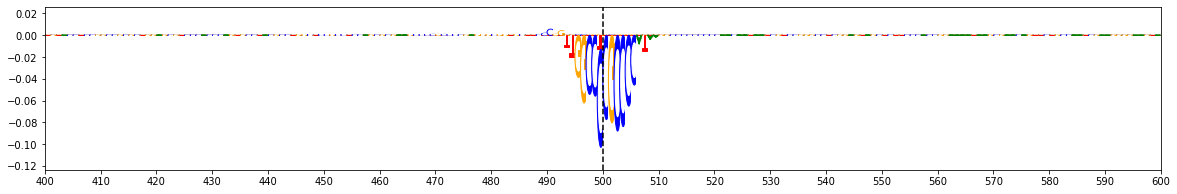



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 169

RSID: rs62054817   ||    chr17 : 45848599 - 45848600   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 1.1366E-22   ||    Coloc: True   ||    Confidence: 1


Noneffect Allele: A   ||   Noneffect Center: 1.5216   ||   Center / 200bp : 0.715

Noneffect Motif: CCAGTAGAGGGC


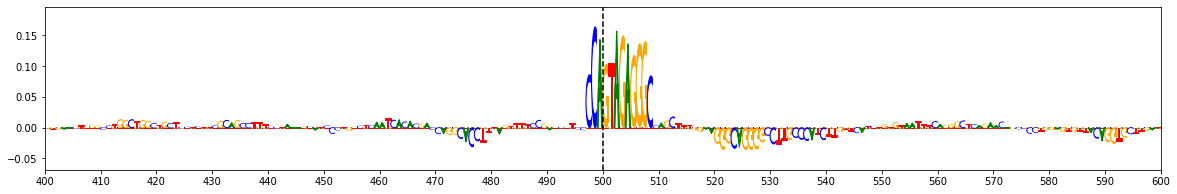

Effect Allele: G   ||   Effect Center: 0.7095   ||   Center / 200bp : 0.5266

Effect Motif: CCAGTAGAGGGC


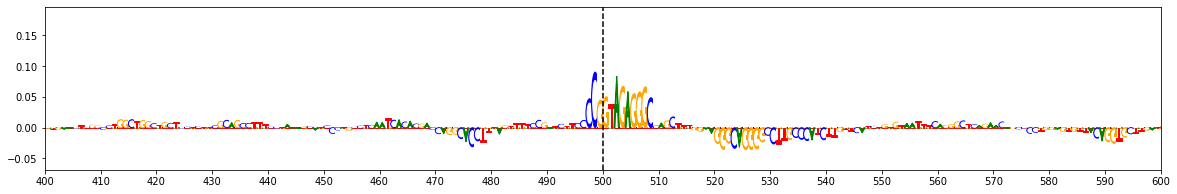

gkmExplain Score: -0.1884  ||  ISM Score: -1.2172  ||  deltaSVM Score: -7.0046

gkmExplain P-Value: 0.054657  ||  ISM P-Value: 0.017177  ||  deltaSVM P-Value: 0.020707

Difference Motif: CC(A/G)GTAGAGGGC


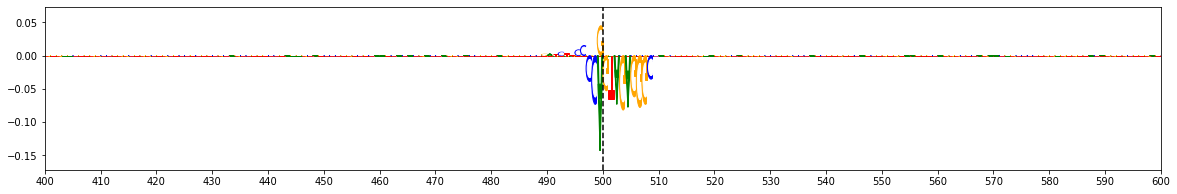



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 421

RSID: rs344791   ||    chr19 : 45326535 - 45326536   ||    Locus: 71   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 1.2157E-04   ||    Coloc: True   ||    Confidence: 1


Noneffect Allele: G   ||   Noneffect Center: 0.351   ||   Center / 200bp : 0.3803

Noneffect Motif: GCCTCCACTGT


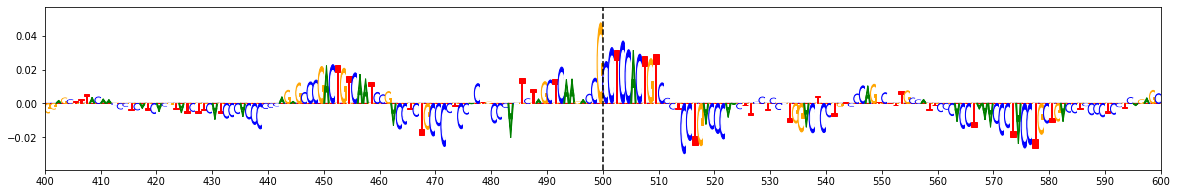

Effect Allele: C   ||   Effect Center: 0.0135   ||   Center / 200bp : 0.2121

Effect Motif: GCCTCCACTGT


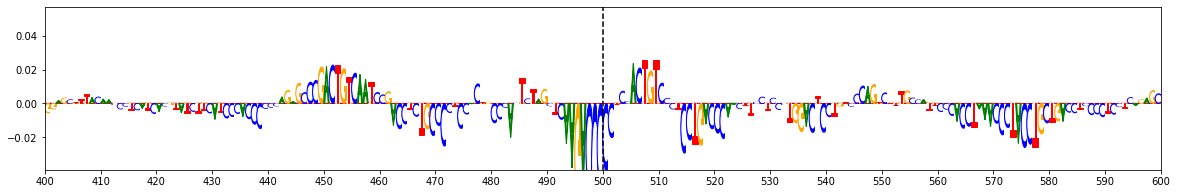

gkmExplain Score: -0.1682  ||  ISM Score: -1.2188  ||  deltaSVM Score: -7.0549

gkmExplain P-Value: 0.068295  ||  ISM P-Value: 0.017103  ||  deltaSVM P-Value: 0.020276

Difference Motif: (G/C)CCTCCACTGT


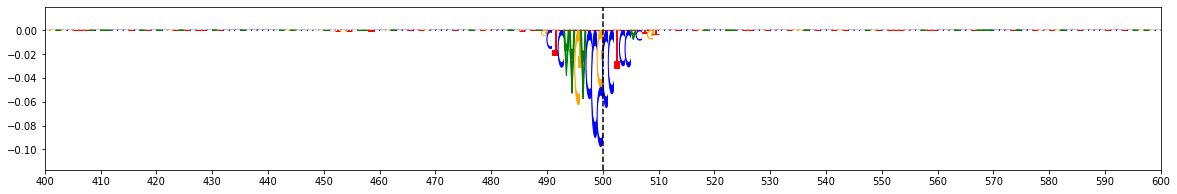



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 481

RSID: rs6781790   ||    chr3 : 49007333 - 49007334   ||    Locus: 92   ||    IDR Peak: True

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 2.3493E-03   ||    Coloc: False   ||    Confidence: 1


Noneffect Allele: C   ||   Noneffect Center: 0.9891   ||   Center / 200bp : 0.3477

Noneffect Motif: GAGGGCGCTGTT


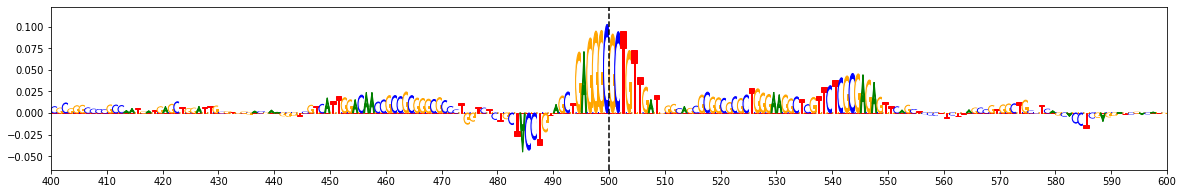

Effect Allele: T   ||   Effect Center: 0.4576   ||   Center / 200bp : 0.2048

Effect Motif: GAGGGCGCTGTT


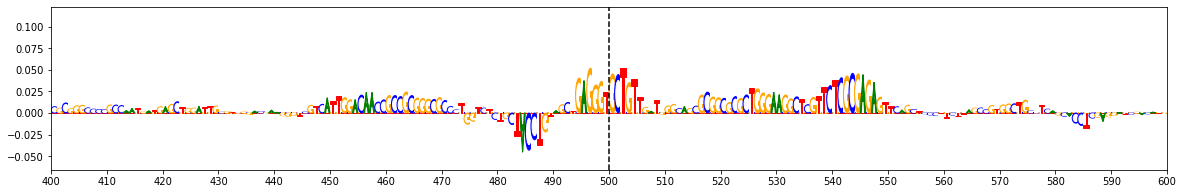

gkmExplain Score: -0.1429  ||  ISM Score: -0.9676  ||  deltaSVM Score: -5.5866

gkmExplain P-Value: 0.093037  ||  ISM P-Value: 0.034561  ||  deltaSVM P-Value: 0.039287

Difference Motif: GAGGG(C/T)GCTGTT


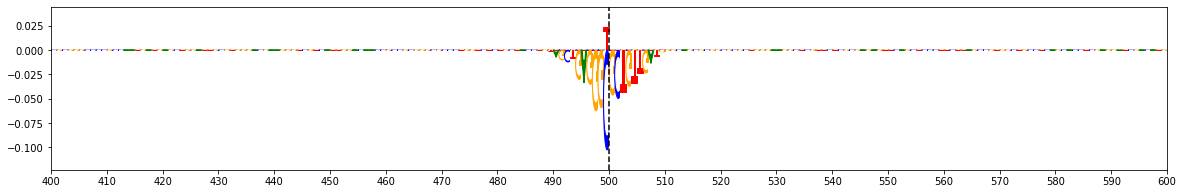



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 51

RSID: rs1237999   ||    chr11 : 86103987 - 86103988   ||    Locus: 16   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 7.1431E-16   ||    Coloc: False   ||    Confidence: 1


Noneffect Allele: G   ||   Noneffect Center: 0.5404   ||   Center / 200bp : 0.1898

Noneffect Motif: GAGTCACCAACA


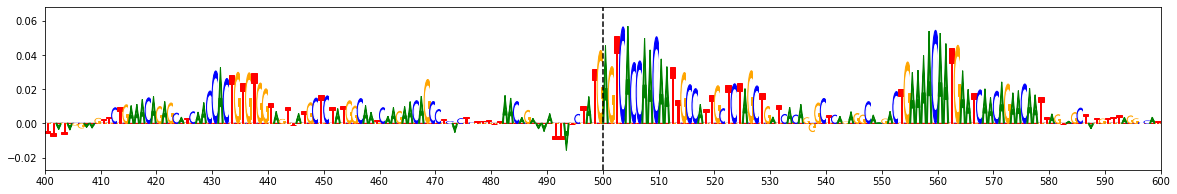

Effect Allele: A   ||   Effect Center: 0.0813   ||   Center / 200bp : 0.0691

Effect Motif: GAGTCACCAACA


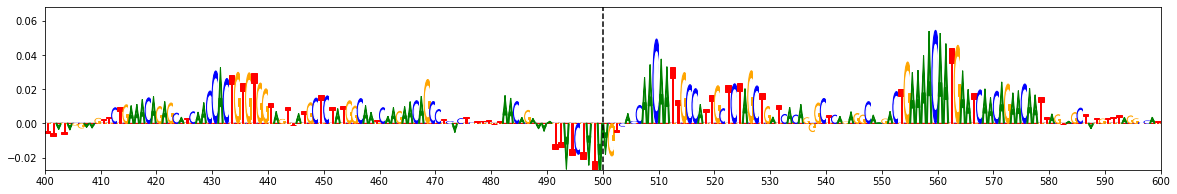

gkmExplain Score: -0.1207  ||  ISM Score: -1.0242  ||  deltaSVM Score: -5.8814

gkmExplain P-Value: 0.126076  ||  ISM P-Value: 0.029225  ||  deltaSVM P-Value: 0.034108

Difference Motif: (G/A)AGTCACCAACA


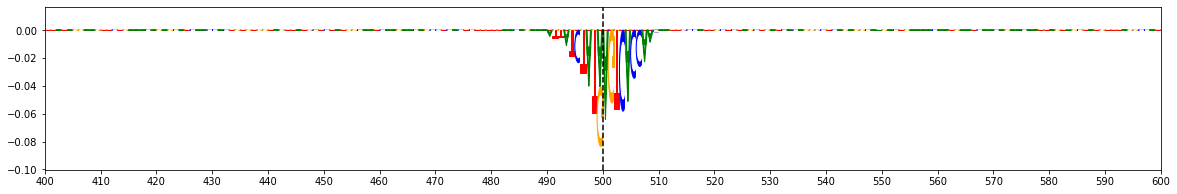



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 334

RSID: rs72914885   ||    chr17 : 78426790 - 78426791   ||    Locus: 62   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 4.4672E-02   ||    Coloc: False   ||    Confidence: 1


Noneffect Allele: A   ||   Noneffect Center: 0.5405   ||   Center / 200bp : 0.2118

Noneffect Motif: ACTGCCAGAGC


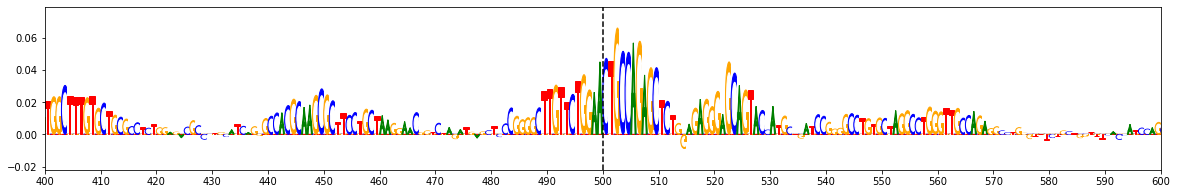

Effect Allele: C   ||   Effect Center: 0.1316   ||   Center / 200bp : 0.0946

Effect Motif: ACTGCCAGAGC


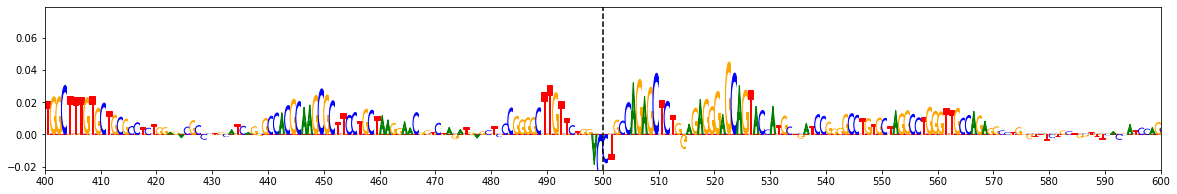

gkmExplain Score: -0.1172  ||  ISM Score: -0.9047  ||  deltaSVM Score: -5.3543

gkmExplain P-Value: 0.132735  ||  ISM P-Value: 0.041934  ||  deltaSVM P-Value: 0.044058

Difference Motif: (A/C)CTGCCAGAGC


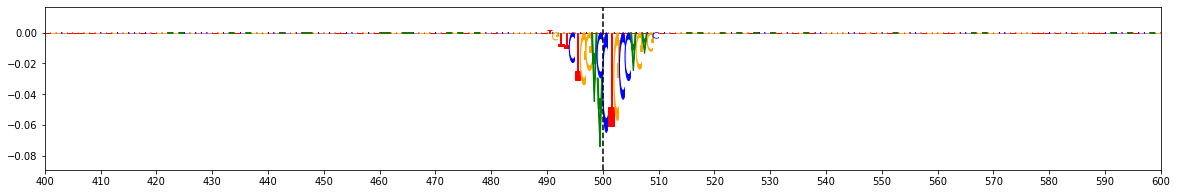



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 356

RSID: rs8103622   ||    chr19 : 18462023 - 18462024   ||    Locus: 69   ||    IDR Peak: True

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 1.2790E-05   ||    Coloc: True   ||    Confidence: 1


Noneffect Allele: C   ||   Noneffect Center: 2.282   ||   Center / 200bp : 0.6568

Noneffect Motif: AGAGCGCCACCTGCTG


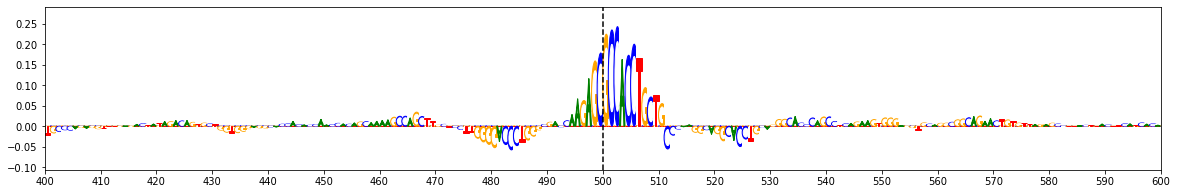

Effect Allele: T   ||   Effect Center: 1.6565   ||   Center / 200bp : 0.5834

Effect Motif: AGAGCGCCACCTGCTG


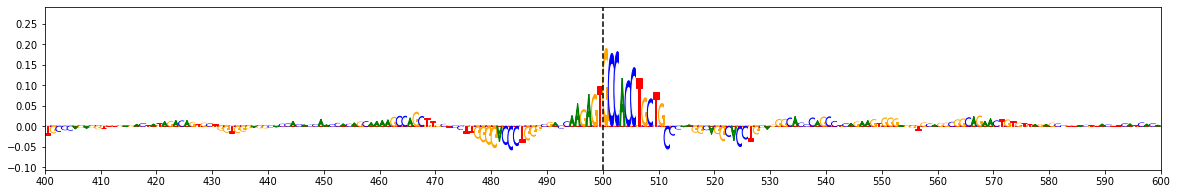

gkmExplain Score: -0.0734  ||  ISM Score: -1.0476  ||  deltaSVM Score: -5.9743

gkmExplain P-Value: 0.270696  ||  ISM P-Value: 0.02731  ||  deltaSVM P-Value: 0.032653

Difference Motif: AGAG(C/T)GCCACCTGCTG


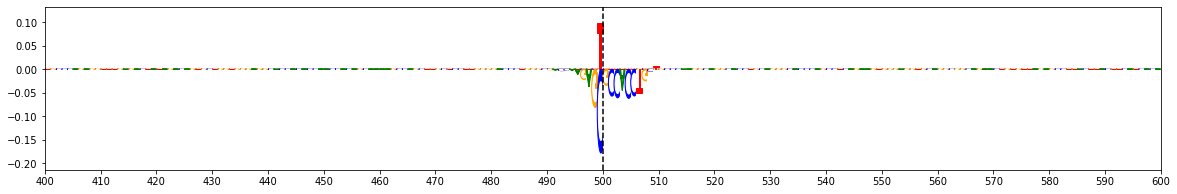



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 324

RSID: rs7218004   ||    chr17 : 75032747 - 75032748   ||    Locus: 61   ||    IDR Peak: True

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 8.5410E-06   ||    Coloc: True   ||    Confidence: 0


Noneffect Allele: G   ||   Noneffect Center: 0.0678   ||   Center / 200bp : 0.0336

Noneffect Motif: CGGGCGGGTT


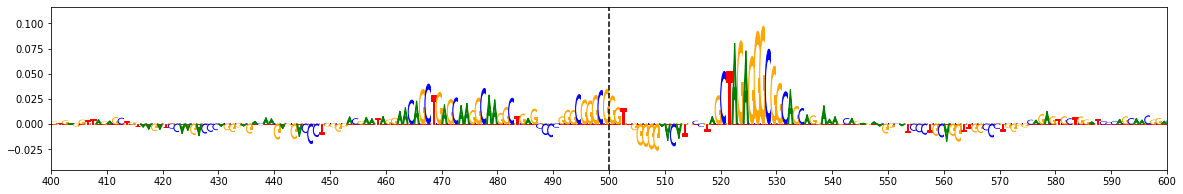

Effect Allele: A   ||   Effect Center: -0.1261   ||   Center / 200bp : 0.0

Effect Motif: CGGGCGGGTT


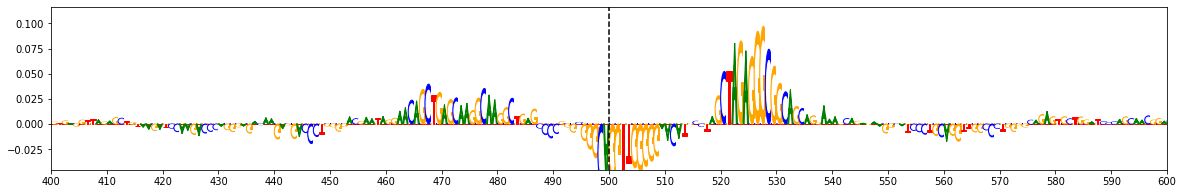

gkmExplain Score: -0.0336  ||  ISM Score: -1.25  ||  deltaSVM Score: -7.1835

gkmExplain P-Value: 0.567455  ||  ISM P-Value: 0.015783  ||  deltaSVM P-Value: 0.019227

Difference Motif: CGGGC(G/A)GGTT


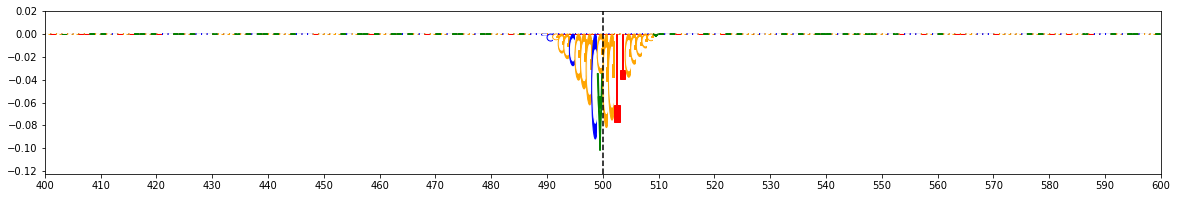



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 205

RSID: rs111972148   ||    chr17 : 45895754 - 45895755   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 3.9382E-22   ||    Coloc: True   ||    Confidence: 0


Noneffect Allele: C   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: CCCACCCCCC


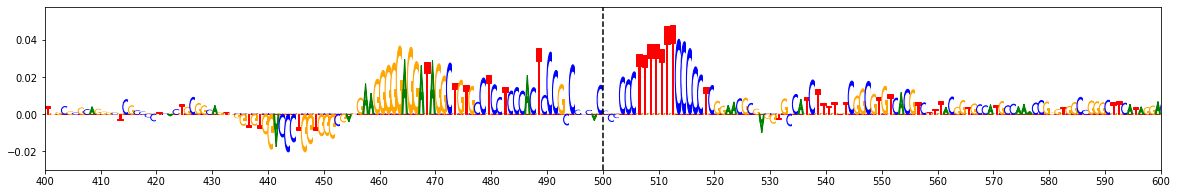

Effect Allele: G   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: CCCACCCCCC


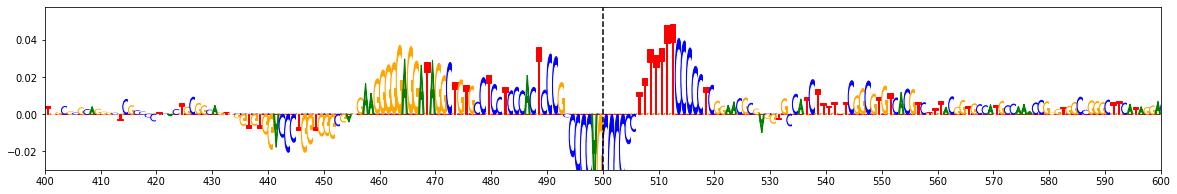

gkmExplain Score: 0.0  ||  ISM Score: -0.9124  ||  deltaSVM Score: -5.5747

gkmExplain P-Value: 0.999999  ||  ISM P-Value: 0.040933  ||  deltaSVM P-Value: 0.039514

Difference Motif: CCCA(C/G)CCCCC


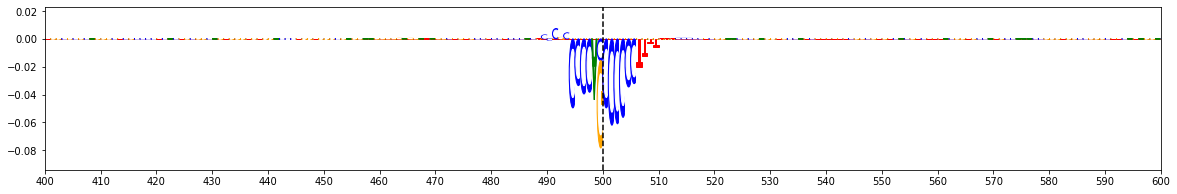



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 192

RSID: rs56365901   ||    chr17 : 45882956 - 45882957   ||    Locus: 54   ||    IDR Peak: False

GWAS: 23andme_PD_hg38   ||    P-Value: 4.4213E-22   ||    Coloc: True   ||    Confidence: 0


Noneffect Allele: A   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: TGGGAGTCTG


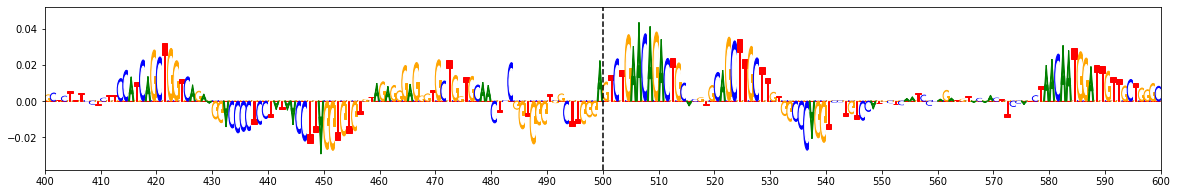

Effect Allele: G   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: TGGGAGTCTG


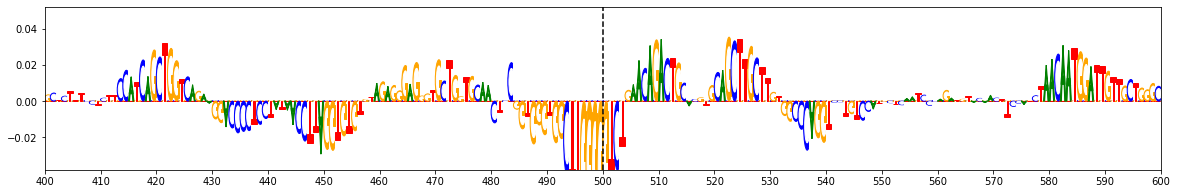

gkmExplain Score: 0.0  ||  ISM Score: -1.2111  ||  deltaSVM Score: -7.2045

gkmExplain P-Value: 0.999999  ||  ISM P-Value: 0.017452  ||  deltaSVM P-Value: 0.019062

Difference Motif: TGGG(A/G)GTCTG


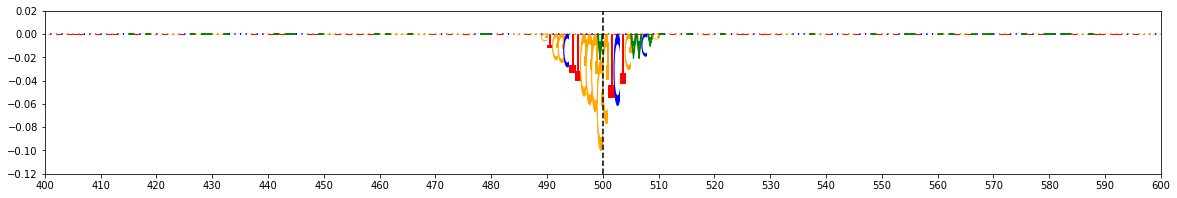



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [18]:
neg_diff_motifs = []

for idx in neg_snps.index:

    print()
    print('Index:', idx)
    print()
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], 
          ':', neg_snps.at[idx, 'start'],
          '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', neg_snps.at[idx, 'locus_num'],
          '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    print()
    print('GWAS:', neg_snps.at[idx, 'gwas'],
          '  ||   ', 'P-Value:', '%.4E' % Decimal(neg_snps.at[idx, 'gwas_pval']),
          '  ||   ', 'Coloc:', neg_snps.at[idx, 'coloc'], 
          '  ||   ', 'Confidence:', neg_snps.at[idx, 'confidence'])
    print()
    print()
    
    if neg_snps.at[idx, 'noneffect'] != 'NAN':
        print('Noneffect Allele:', neg_snps.at[idx, 'noneffect'],
              '  ||   Noneffect Center:', round(neg_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Noneffect Motif:', neg_snps.at[idx, 'motif'])
    else:
        print('Major Allele:', neg_snps.at[idx, 'major'],
              '  ||   Major Center:', round(neg_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Major Motif:', neg_snps.at[idx, 'motif'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_noneffect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(noneffect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    if neg_snps.at[idx, 'effect'] != 'NAN':
        print('Effect Allele:', neg_snps.at[idx, 'effect'],
              '  ||   Effect Center:', round(neg_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Effect Motif:', neg_snps.at[idx, 'motif'])
    else:
        print('Minor Allele:', neg_snps.at[idx, 'minor'].split(',')[0],
              '  ||   Minor Center:', round(neg_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Minor Motif:', neg_snps.at[idx, 'motif'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_effect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(effect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('gkmExplain Score:',
          round(neg_snps.at[idx, 'ratio_score'], 4),
          ' ||  ISM Score:', round(neg_snps.at[idx, 'ism_score'], 4),
          ' ||  deltaSVM Score:', round(neg_snps.at[idx, 'delta_score'], 4))
    print()
    print('gkmExplain P-Value:', round(neg_snps.at[idx, 'ratio_pval'], 6),
          ' ||  ISM P-Value:', round(neg_snps.at[idx, 'ism_pval'], 6),
          ' ||  deltaSVM P-Value:', round(neg_snps.at[idx, 'delta_pval'], 6))
    print()
    if neg_snps.at[idx, 'noneffect'] != 'NAN':
        diff_motif = (noneffect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + neg_snps.at[idx, 'noneffect']
                      + '/' + neg_snps.at[idx, 'effect']
                      + ')' + noneffect_seqs[idx][500:sig_list[idx][6]])
    else:
        diff_motif = (noneffect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + neg_snps.at[idx, 'major']
                      + '/' + neg_snps.at[idx, 'minor']
                      + ')' + noneffect_seqs[idx][500:sig_list[idx][6]])
    print('Difference Motif:', diff_motif)
    neg_diff_motifs.append(diff_motif)
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx],
                     subticks_frequency=10, xlim=(400,600))
    
    print()
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()
    
neg_snps['diff_motif'] = neg_diff_motifs

# Visualize Top Positive Scoring SNPs <a name='pos_snps' />


Index: 177

RSID: rs62054825   ||    chr17 : 45852666 - 45852667   ||    Locus: 54   ||    IDR Peak: False

GWAS: 23andme_PD_hg38   ||    P-Value: 1.2470E-22   ||    Coloc: True   ||    Confidence: 2


Effect Allele: G   ||   Effect Center: 0.8033   ||   Center / 200bp : 0.6589

Effect Motif: CCCGGAAGTGGAGT


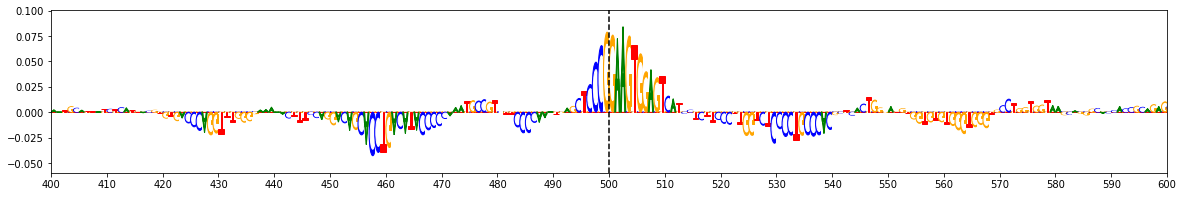

Noneffect Allele: A   ||   Noneffect Center: 0.1227   ||   Center / 200bp : 0.2677

Noneffect Motif: CCCGGAAGTGGAGT


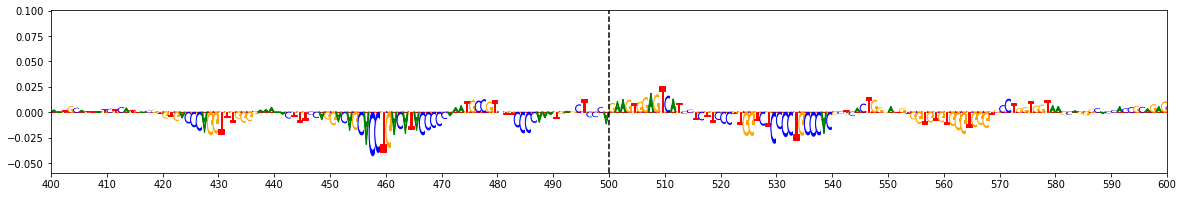

gkmExplain Score: 0.3912  ||  ISM Score: 1.1146  ||  deltaSVM Score: 6.3675

gkmExplain P-Value: 0.011806  ||  ISM P-Value: 0.022614  ||  deltaSVM P-Value: 0.02728

Difference Motif: CCC(G/A)GAAGTGGAGT


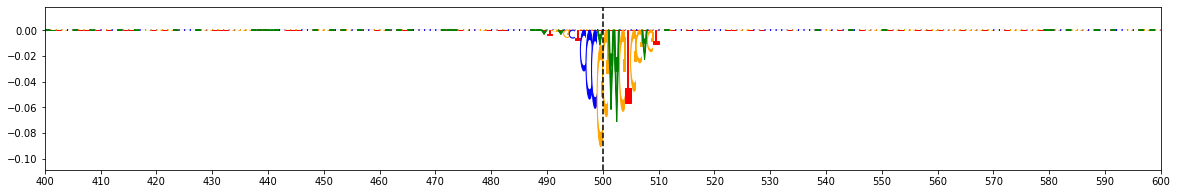



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 247

RSID: rs62062786   ||    chr17 : 45947293 - 45947294   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 4.5296E-22   ||    Coloc: True   ||    Confidence: 2


Effect Allele: G   ||   Effect Center: 0.4592   ||   Center / 200bp : 0.3498

Effect Motif: CAGCTGCCACA


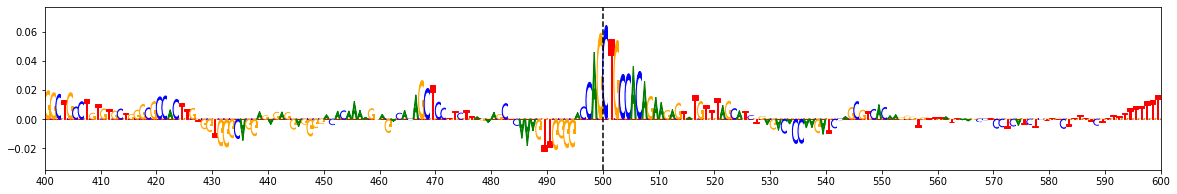

Noneffect Allele: C   ||   Noneffect Center: -0.5895   ||   Center / 200bp : 0.0

Noneffect Motif: CAGCTGCCACA


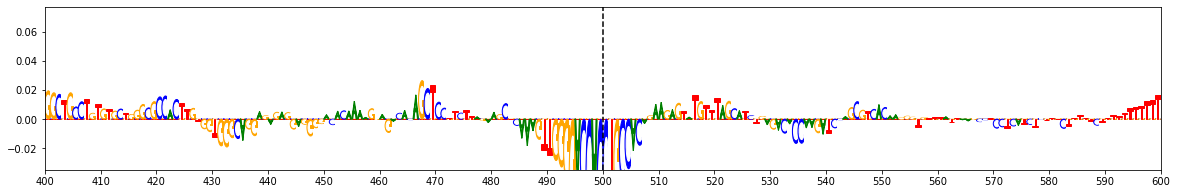

gkmExplain Score: 0.3498  ||  ISM Score: 2.111  ||  deltaSVM Score: 12.0692

gkmExplain P-Value: 0.015033  ||  ISM P-Value: 0.002691  ||  deltaSVM P-Value: 0.003835

Difference Motif: CA(G/C)CTGCCACA


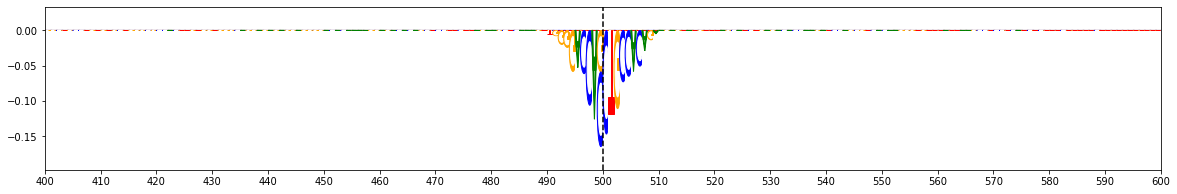



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 211

RSID: rs62056782   ||    chr17 : 45896863 - 45896864   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 3.9386E-22   ||    Coloc: True   ||    Confidence: 2


Effect Allele: T   ||   Effect Center: 1.5844   ||   Center / 200bp : 0.6484

Effect Motif: CGCCCTCTTGTG


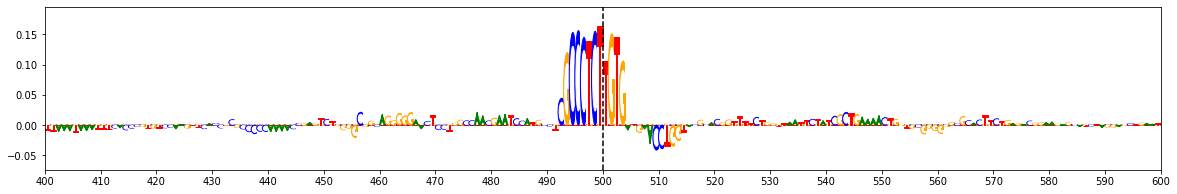

Noneffect Allele: C   ||   Noneffect Center: 0.3922   ||   Center / 200bp : 0.3144

Noneffect Motif: CGCCCTCTTGTG


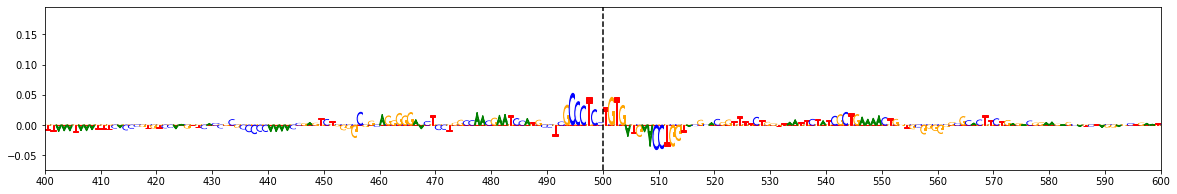

gkmExplain Score: 0.3341  ||  ISM Score: 1.9518  ||  deltaSVM Score: 11.2081

gkmExplain P-Value: 0.016594  ||  ISM P-Value: 0.003541  ||  deltaSVM P-Value: 0.004865

Difference Motif: CGCCCTC(T/C)TGTG


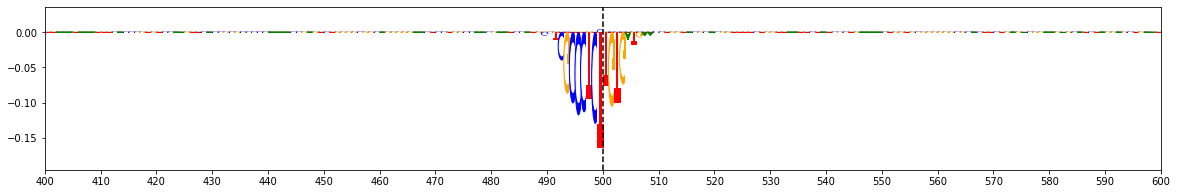



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 32

RSID: rs636317   ||    chr11 : 60251676 - 60251677   ||    Locus: 11   ||    IDR Peak: False

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 5.9060E-15   ||    Coloc: False   ||    Confidence: 2


Effect Allele: C   ||   Effect Center: 3.1274   ||   Center / 200bp : 0.6989

Effect Motif: TGCTGCCATCTGCTGG


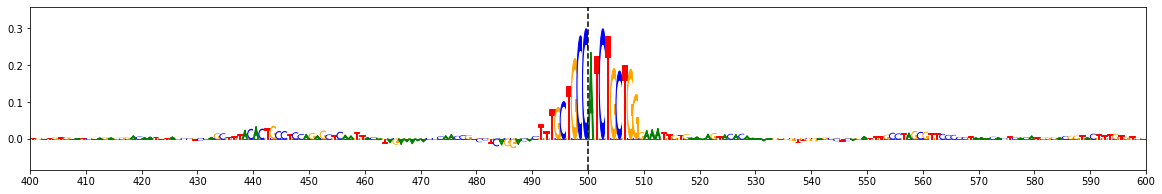

Noneffect Allele: T   ||   Noneffect Center: 0.8709   ||   Center / 200bp : 0.4002

Noneffect Motif: TGCTGCCATCTGCTGG


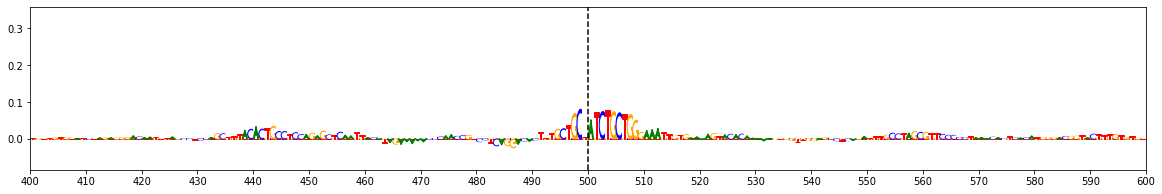

gkmExplain Score: 0.2986  ||  ISM Score: 3.5858  ||  deltaSVM Score: 20.6859

gkmExplain P-Value: 0.021085  ||  ISM P-Value: 0.0004  ||  deltaSVM P-Value: 0.00065

Difference Motif: TGCTGC(C/T)ATCTGCTGG


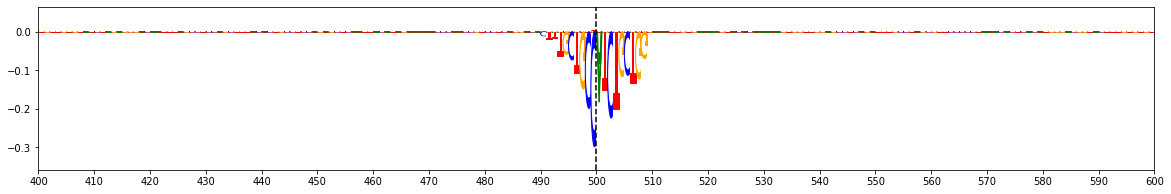



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 232

RSID: rs62061716   ||    chr17 : 45934729 - 45934730   ||    Locus: 54   ||    IDR Peak: False

GWAS: 23andme_PD_hg38   ||    P-Value: 4.0364E-22   ||    Coloc: True   ||    Confidence: 2


Effect Allele: G   ||   Effect Center: 1.113   ||   Center / 200bp : 0.4875

Effect Motif: CTCTAGGAGGCAGTA


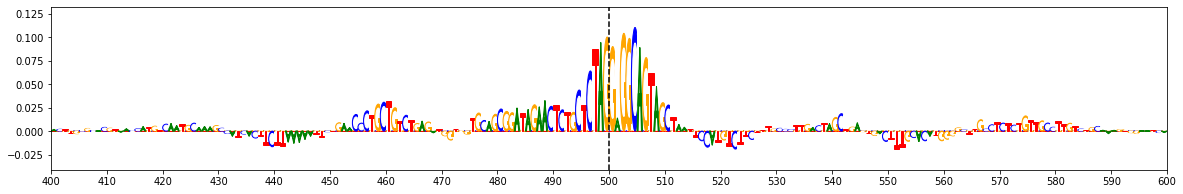

Noneffect Allele: A   ||   Noneffect Center: 0.4472   ||   Center / 200bp : 0.2725

Noneffect Motif: CTCTAGGAGGCAGTA


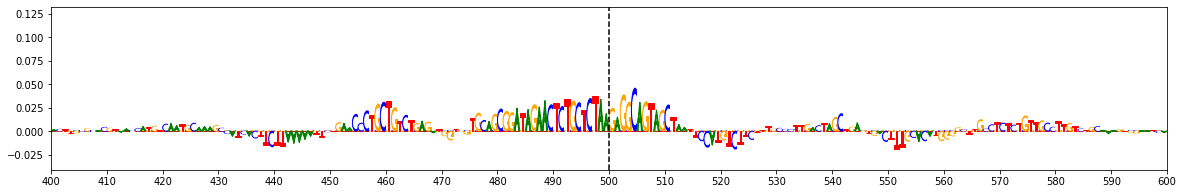

gkmExplain Score: 0.215  ||  ISM Score: 0.9995  ||  deltaSVM Score: 5.6904

gkmExplain P-Value: 0.041876  ||  ISM P-Value: 0.031422  ||  deltaSVM P-Value: 0.03736

Difference Motif: CTCTA(G/A)GAGGCAGTA


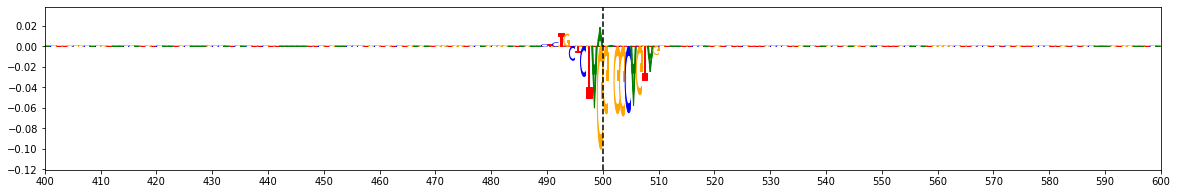



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 314

RSID: rs199523   ||    chr17 : 46771150 - 46771151   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 9.4929E-14   ||    Coloc: True   ||    Confidence: 2


Effect Allele: C   ||   Effect Center: 1.0422   ||   Center / 200bp : 0.3846

Effect Motif: GCGCCACCTACAG


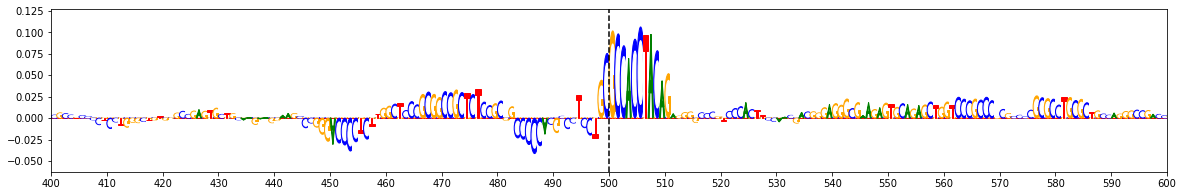

Noneffect Allele: A   ||   Noneffect Center: 0.2897   ||   Center / 200bp : 0.171

Noneffect Motif: GCGCCACCTACAG


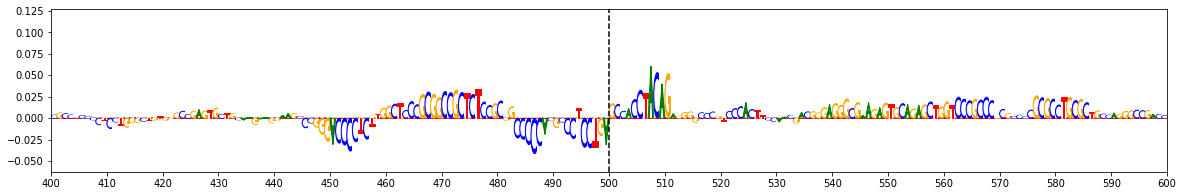

gkmExplain Score: 0.2136  ||  ISM Score: 1.3284  ||  deltaSVM Score: 7.6621

gkmExplain P-Value: 0.042441  ||  ISM P-Value: 0.012977  ||  deltaSVM P-Value: 0.01587

Difference Motif: G(C/A)GCCACCTACAG


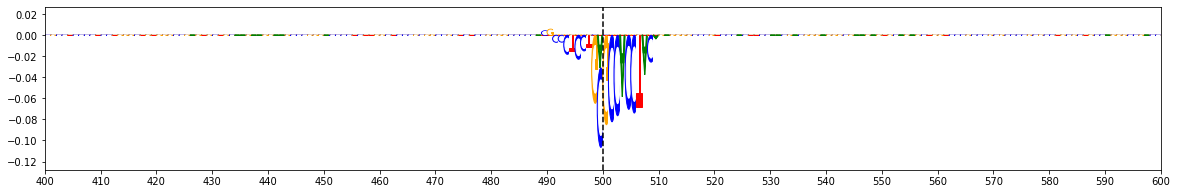



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 213

RSID: rs80346216   ||    chr17 : 45897109 - 45897110   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 3.9387E-22   ||    Coloc: True   ||    Confidence: 1


Effect Allele: T   ||   Effect Center: 1.0561   ||   Center / 200bp : 0.3342

Effect Motif: GCCGCTAGGGG


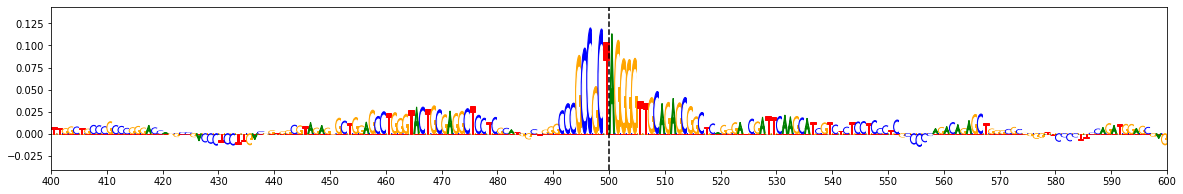

Noneffect Allele: G   ||   Noneffect Center: 0.4928   ||   Center / 200bp : 0.1966

Noneffect Motif: GCCGCTAGGGG


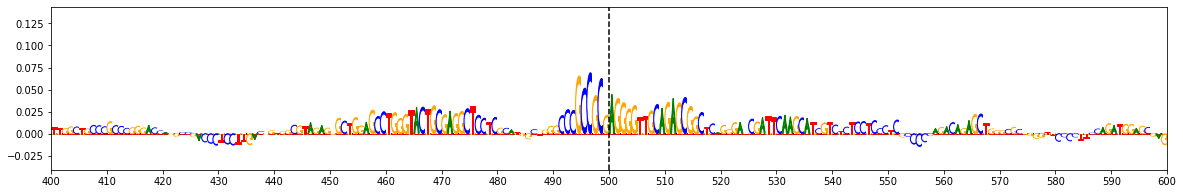

gkmExplain Score: 0.1376  ||  ISM Score: 1.0182  ||  deltaSVM Score: 5.815

gkmExplain P-Value: 0.099808  ||  ISM P-Value: 0.02974  ||  deltaSVM P-Value: 0.035197

Difference Motif: GCCGC(T/G)AGGGG


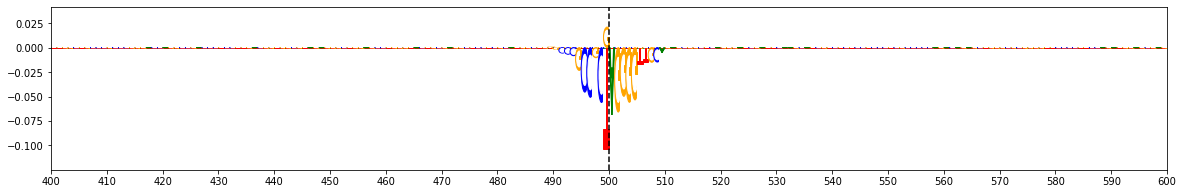



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 236

RSID: rs62061720   ||    chr17 : 45935822 - 45935823   ||    Locus: 54   ||    IDR Peak: False

GWAS: 23andme_PD_hg38   ||    P-Value: 4.0363E-22   ||    Coloc: True   ||    Confidence: 0


Effect Allele: T   ||   Effect Center: 0.0668   ||   Center / 200bp : 0.041

Effect Motif: CACTTTCTCC


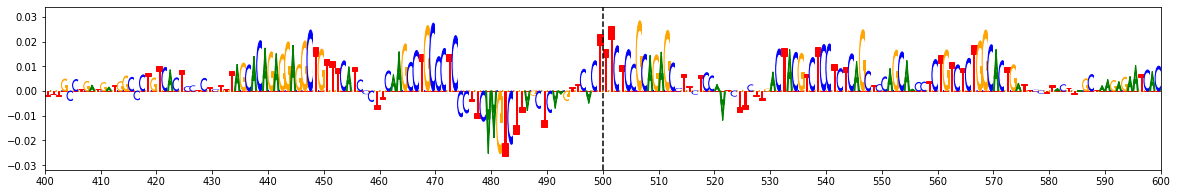

Noneffect Allele: C   ||   Noneffect Center: -0.1034   ||   Center / 200bp : 0.0

Noneffect Motif: CACTTTCTCC


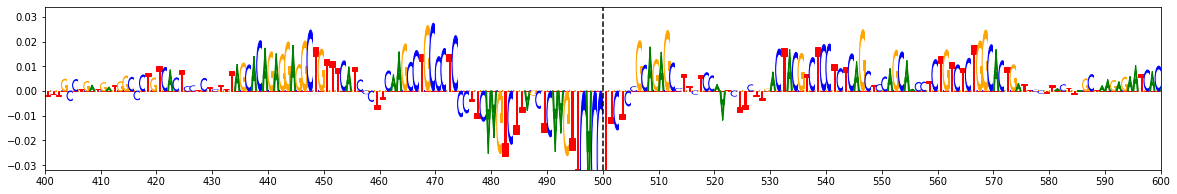

gkmExplain Score: 0.041  ||  ISM Score: 0.9127  ||  deltaSVM Score: 5.2513

gkmExplain P-Value: 0.493716  ||  ISM P-Value: 0.040892  ||  deltaSVM P-Value: 0.046399

Difference Motif: CAC(T/C)TTCTCC


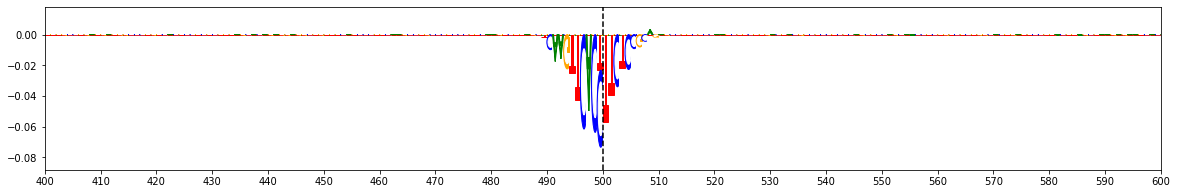



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 428

RSID: rs2248415   ||    chr2 : 95297493 - 95297494   ||    Locus: 85   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 7.8283E-03   ||    Coloc: False   ||    Confidence: 0


Effect Allele: G   ||   Effect Center: 0.0279   ||   Center / 200bp : 0.0301

Effect Motif: GGGTGGGGGG


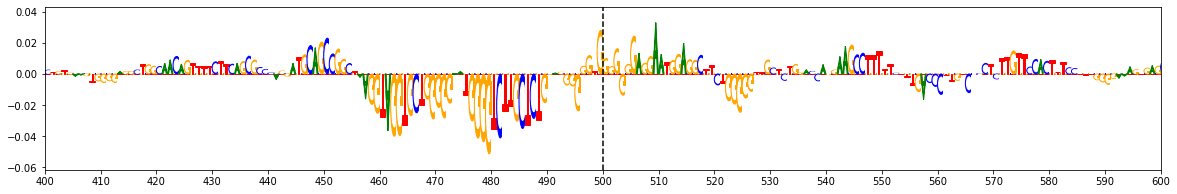

Noneffect Allele: C   ||   Noneffect Center: -0.0665   ||   Center / 200bp : 0.0

Noneffect Motif: GGGTGGGGGG


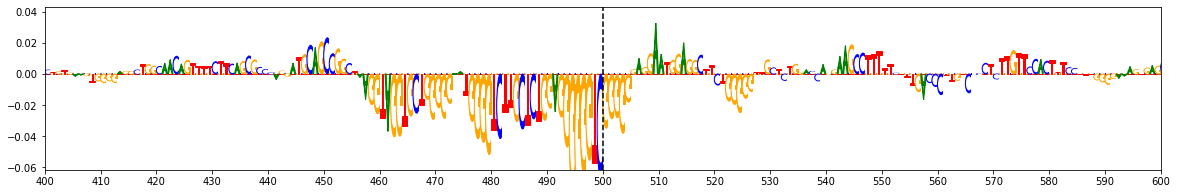

gkmExplain Score: 0.0301  ||  ISM Score: 1.1916  ||  deltaSVM Score: 6.8907

gkmExplain P-Value: 0.605394  ||  ISM P-Value: 0.018369  ||  deltaSVM P-Value: 0.021724

Difference Motif: GGGT(G/C)GGGGG


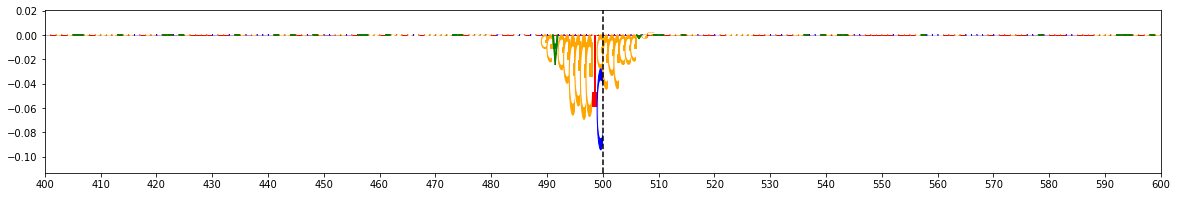



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 595

RSID: rs3735901   ||    chr8 : 22604860 - 22604861   ||    Locus: 125   ||    IDR Peak: True

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 5.0811E-02   ||    Coloc: False   ||    Confidence: 0


Effect Allele: T   ||   Effect Center: 0.0497   ||   Center / 200bp : 0.0284

Effect Motif: CCCCTGCCGC


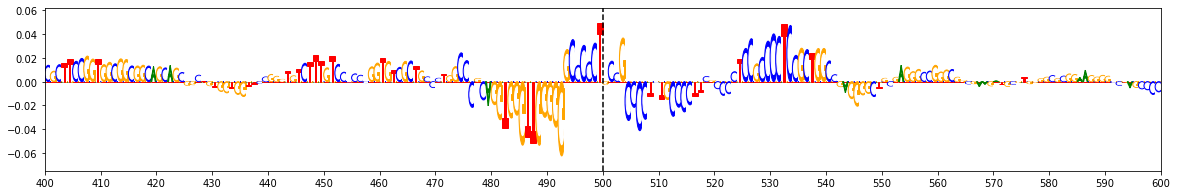

Noneffect Allele: C   ||   Noneffect Center: -0.0508   ||   Center / 200bp : 0.0

Noneffect Motif: CCCCTGCCGC


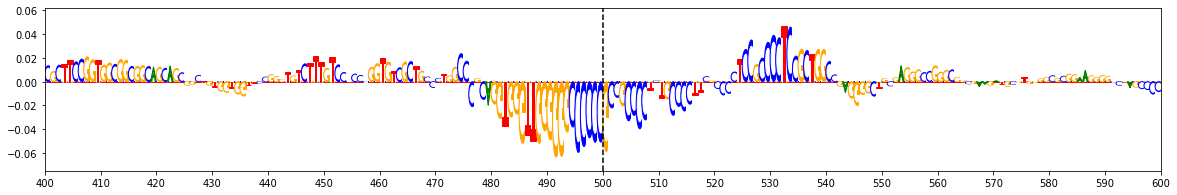

gkmExplain Score: 0.0284  ||  ISM Score: 1.1982  ||  deltaSVM Score: 7.846

gkmExplain P-Value: 0.624559  ||  ISM P-Value: 0.018052  ||  deltaSVM P-Value: 0.014778

Difference Motif: CCCC(T/C)GCCGC


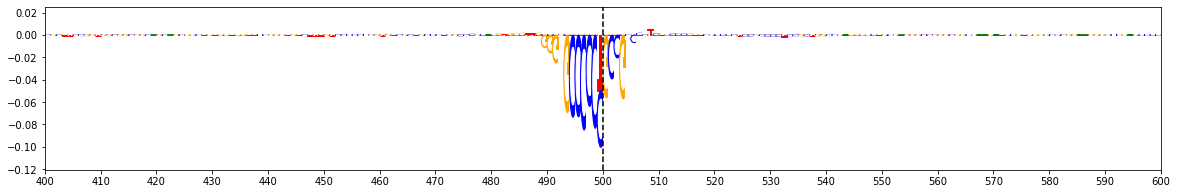



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 487

RSID: rs149776414   ||    chr3 : 52307781 - 52307782   ||    Locus: 93   ||    IDR Peak: False

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 1.0025E-03   ||    Coloc: False   ||    Confidence: 0


Effect Allele: G   ||   Effect Center: 0.0358   ||   Center / 200bp : 0.0233

Effect Motif: GCCCGCCAGG


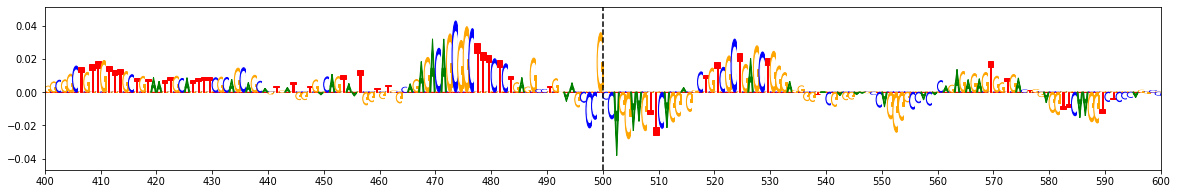

Noneffect Allele: A   ||   Noneffect Center: -0.0486   ||   Center / 200bp : 0.0

Noneffect Motif: GCCCGCCAGG


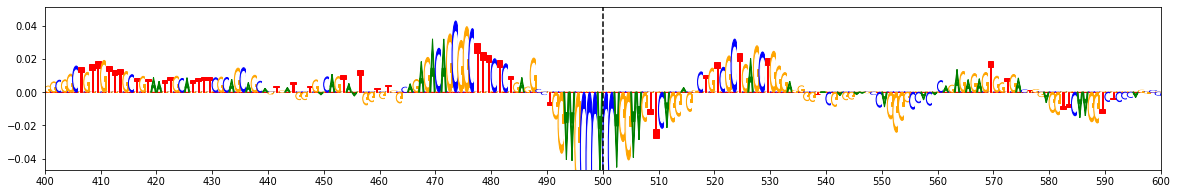

gkmExplain Score: 0.0233  ||  ISM Score: 1.0809  ||  deltaSVM Score: 6.2614

gkmExplain P-Value: 0.685678  ||  ISM P-Value: 0.024839  ||  deltaSVM P-Value: 0.028615

Difference Motif: GCCC(G/A)CCAGG


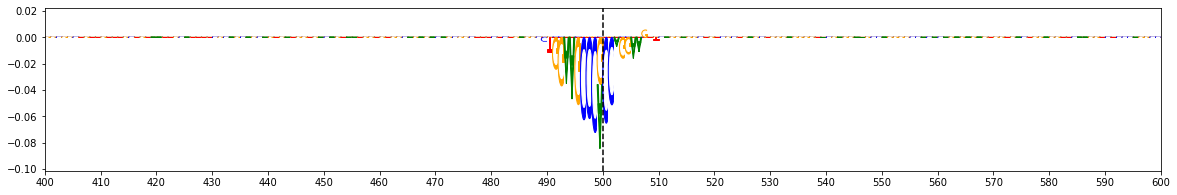



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 239

RSID: rs62061732   ||    chr17 : 45940574 - 45940575   ||    Locus: 54   ||    IDR Peak: False

GWAS: 23andme_PD_hg38   ||    P-Value: 3.0356E-22   ||    Coloc: True   ||    Confidence: 0


Effect Allele: T   ||   Effect Center: 0.022   ||   Center / 200bp : 0.0166

Effect Motif: CCCAGTTAAG


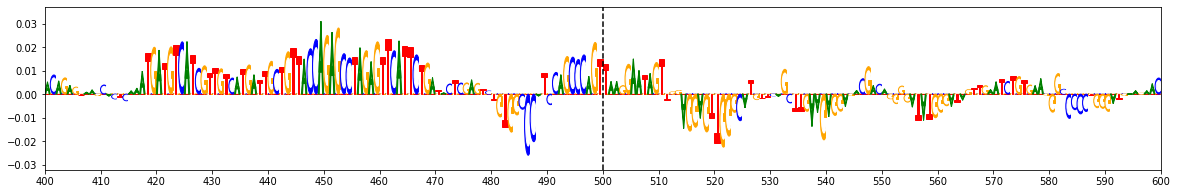

Noneffect Allele: G   ||   Noneffect Center: -0.0556   ||   Center / 200bp : 0.0

Noneffect Motif: CCCAGTTAAG


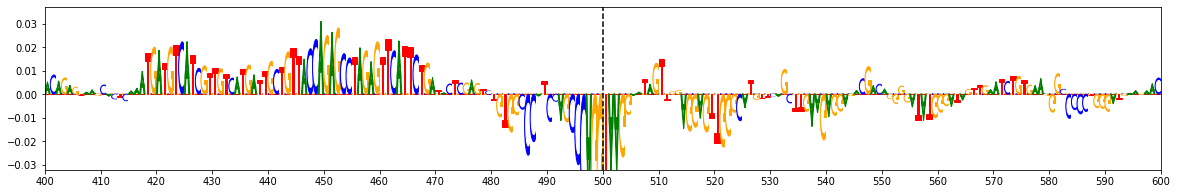

gkmExplain Score: 0.0166  ||  ISM Score: 1.0625  ||  deltaSVM Score: 6.1209

gkmExplain P-Value: 0.770464  ||  ISM P-Value: 0.026169  ||  deltaSVM P-Value: 0.030508

Difference Motif: CCCAG(T/G)TAAG


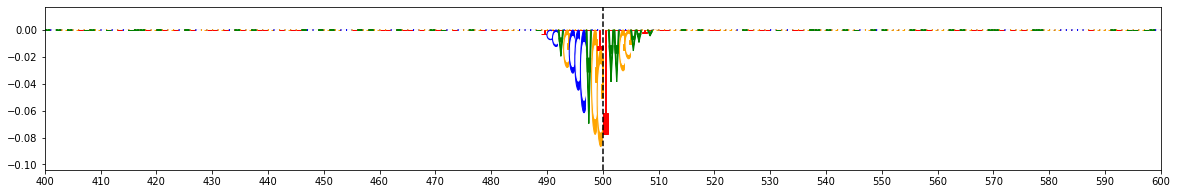



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 384

RSID: rs12691088   ||    chr19 : 44915228 - 44915229   ||    Locus: 71   ||    IDR Peak: True

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 2.6900E-238   ||    Coloc: True   ||    Confidence: 0


Effect Allele: A   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: GGGTAGGGGG


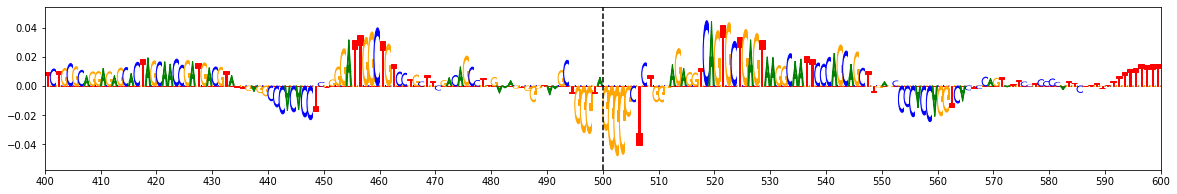

Noneffect Allele: G   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: GGGTAGGGGG


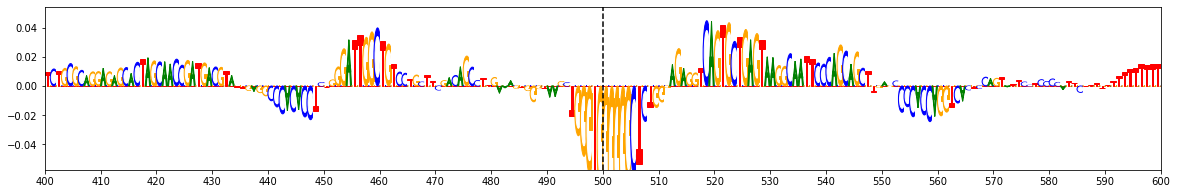

gkmExplain Score: 0.0  ||  ISM Score: 1.0686  ||  deltaSVM Score: 6.1722

gkmExplain P-Value: 0.999999  ||  ISM P-Value: 0.02572  ||  deltaSVM P-Value: 0.029799

Difference Motif: GGGT(A/G)GGGGG


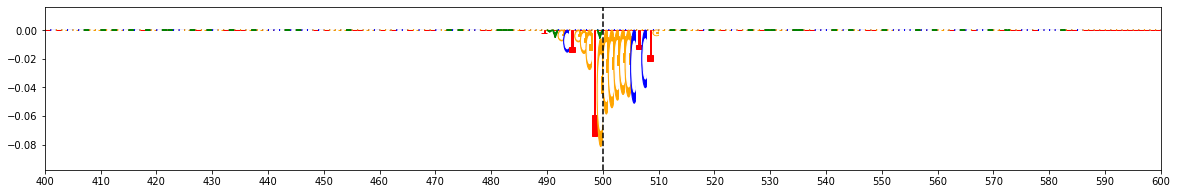



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 170

RSID: rs62054818   ||    chr17 : 45848689 - 45848690   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 1.8453E-22   ||    Coloc: True   ||    Confidence: 0


Effect Allele: C   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: TTACCGGTGC


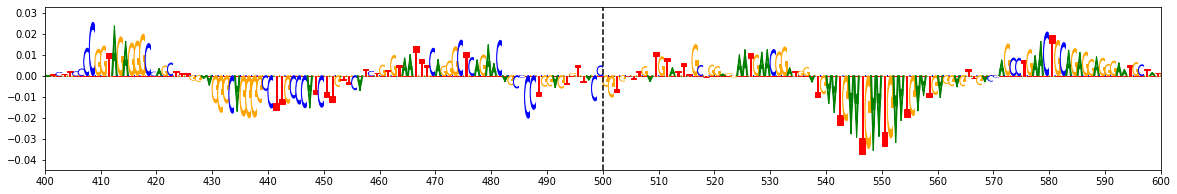

Noneffect Allele: A   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: TTACCGGTGC


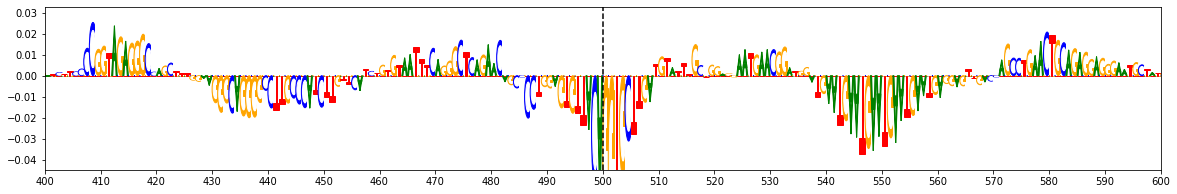

gkmExplain Score: 0.0  ||  ISM Score: 0.9651  ||  deltaSVM Score: 5.5297

gkmExplain P-Value: 0.999999  ||  ISM P-Value: 0.034823  ||  deltaSVM P-Value: 0.040395

Difference Motif: TTAC(C/A)GGTGC


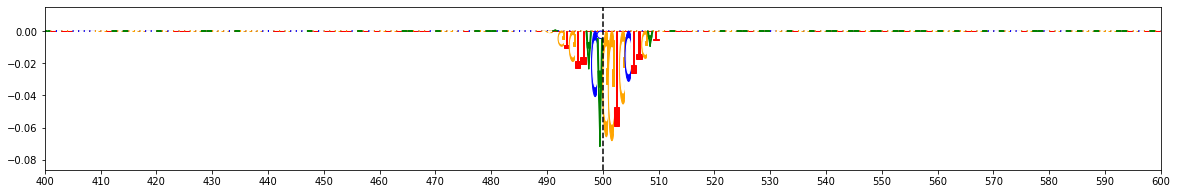



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [19]:
pos_diff_motifs = []

for idx in pos_snps.index:

    print()
    print('Index:', idx)
    print()
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], 
          ':', pos_snps.at[idx, 'start'],
          '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', pos_snps.at[idx, 'locus_num'],
          '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    print()
    print('GWAS:', pos_snps.at[idx, 'gwas'],
          '  ||   ', 'P-Value:', '%.4E' % Decimal(pos_snps.at[idx, 'gwas_pval']),
          '  ||   ', 'Coloc:', pos_snps.at[idx, 'coloc'], 
          '  ||   ', 'Confidence:', pos_snps.at[idx, 'confidence'])
    print()
    print()
    
    if pos_snps.at[idx, 'effect'] != 'NAN':
        print('Effect Allele:', pos_snps.at[idx, 'effect'],
              '  ||   Effect Center:', round(pos_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Effect Motif:', pos_snps.at[idx, 'motif'])
    else:
        print('Minor Allele:', pos_snps.at[idx, 'minor'].split(',')[0],
              '  ||   Minor Center:', round(pos_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Minor Motif:', pos_snps.at[idx, 'motif'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_effect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(effect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    if pos_snps.at[idx, 'noneffect'] != 'NAN':
        print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'],
              '  ||   Noneffect Center:', round(pos_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Noneffect Motif:', pos_snps.at[idx, 'motif'])
    else:
        print('Major Allele:', pos_snps.at[idx, 'major'],
              '  ||   Major Center:', round(pos_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Major Motif:', pos_snps.at[idx, 'motif'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_noneffect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(noneffect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('gkmExplain Score:',
          round(pos_snps.at[idx, 'ratio_score'], 4),
          ' ||  ISM Score:', round(pos_snps.at[idx, 'ism_score'], 4),
          ' ||  deltaSVM Score:', round(pos_snps.at[idx, 'delta_score'], 4))
    print()
    print('gkmExplain P-Value:', round(pos_snps.at[idx, 'ratio_pval'], 6),
          ' ||  ISM P-Value:', round(pos_snps.at[idx, 'ism_pval'], 6),
          ' ||  deltaSVM P-Value:', round(pos_snps.at[idx, 'delta_pval'], 6))
    print()
    if pos_snps.at[idx, 'effect'] != 'NAN':
        diff_motif = (effect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + pos_snps.at[idx, 'effect']
                      + '/' + pos_snps.at[idx, 'noneffect']
                      + ')' + effect_seqs[idx][500:sig_list[idx][6]])
        print('Difference Motif:', diff_motif)
    else:
        diff_motif = (effect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + pos_snps.at[idx, 'minor']
                      + '/' + pos_snps.at[idx, 'major']
                      + ')' + effect_seqs[idx][500:sig_list[idx][6]])
        print('Difference Motif:', diff_motif)
    pos_diff_motifs.append(diff_motif)
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx],
                     subticks_frequency=10, xlim=(400,600))
    
    print()
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()
    
pos_snps['diff_motif'] = pos_diff_motifs

# Generate Signal Tracks

In [20]:
clust_to_celltype = {1: 'excitatory_neurons', 
                     2: 'inhibitory_neurons',
                     3: 'excitatory_neurons',
                     4: 'excitatory_neurons',
                     5: 'nigral_neurons',
                     6: 'nigral_neurons',
                     7: 'unknown_neurons',
                     8: 'opcs',
                     9: 'opcs',
                     10: 'opcs',
                     11: 'inhibitory_neurons',
                     12: 'inhibitory_neurons',
                     13: 'astrocytes',
                     14: 'astrocytes',
                     15: 'astrocytes',
                     16: 'astrocytes',
                     17: 'astrocytes',
                     18: 'doublets',
                     19: 'oligodendrocytes',
                     20: 'oligodendrocytes',
                     21: 'oligodendrocytes',
                     22: 'oligodendrocytes',
                     23: 'oligodendrocytes',
                     24: 'microglia'}

celltype = clust_to_celltype[cluster_input]

sig_snps = neg_snps.append(pos_snps)
tomtom = ['---' for x in range(len(sig_snps))]
fc_tracks = []
pval_tracks = []
tfactors = ['---' for x in range(len(sig_snps))]
annotations = ['---' for x in range(len(sig_snps))]

for index, row in sig_snps.iterrows():
    chrom = row['chr']
    start = row['start'] - 2500
    end = row['end'] + 2500
    rsid = row['rsid']
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/fc_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snp_fc_signal_tracks/{rsid}.fc.png
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/pval_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snp_pval_signal_tracks/{rsid}.pval.png
    fc_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/snp_fc_signal_tracks/'+rsid+'.fc.png')
    pval_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/snp_pval_signal_tracks/'+rsid+'.pval.png')
        
sig_snps['tomtom'] = tomtom
sig_snps['fc_track'] = fc_tracks
sig_snps['pval_track'] = pval_tracks
sig_snps['tfactor'] = tfactors
sig_snps['annotation'] = annotations

sig_snps = sig_snps[['chr', 'start', 'end', 'rsid',
                     'effect', 'noneffect', 'direction',
                     'locus_num', 'gwas', 'gwas_pval', 'coloc',
                     'idr_peak', 'ism_pval', 'delta_pval', 'ratio_pval',
                     'confidence', 'motif', 'diff_motif', 'tomtom', 'fc_track',
                     'pval_track', 'tfactor', 'annotation']]

sig_snps.rename(columns = {'ratio_pval': 'explain_pval'}, inplace=True)
sig_snps.sort_values(by=['explain_pval'], ascending=True, inplace=True)

INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.0827186107635498
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 1

INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pyge

INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
I

INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometra

INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.08713269233703613
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plottin

INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
I

INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygen

INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.06281208992004395
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [

INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
I

INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:

INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 560.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.06147956848144531
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cl

INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:

INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INF

INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.07118582725524902
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 

INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:py

INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
I

INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometra

INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.0808861255645752
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting

INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
I

INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygen

# Save Significant SNPs

In [21]:
sig_snps.to_csv('/mnt/lab_data3/soumyak/adpd/sig_snps/Cluster'
                + cluster
                + '.'
                + celltype
                + '.snps.csv',
                sep='\t', index=False)

# Final SNP Table <a name='final_table' />

In [22]:
display(sig_snps)

,chr,start,end,rsid,effect,noneffect,direction,locus_num,gwas,gwas_pval,coloc,idr_peak,ism_pval,delta_pval,explain_pval,confidence,motif,diff_motif,tomtom,fc_track,pval_track,tfactor,annotation
177,chr17,45852666,45852667,rs62054825,G,A,+,54,23andme_PD_hg38,1.247000e-22,True,False,0.022614,0.027280,0.011806,2,CCCGGAAGTGGAGT,CCC(G/A)GAAGTGGAGT,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
247,chr17,45947293,45947294,rs62062786,G,C,+,54,23andme_PD_hg38,4.529580e-22,True,True,0.002691,0.003835,0.015033,2,CAGCTGCCACA,CA(G/C)CTGCCACA,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
211,chr17,45896863,45896864,rs62056782,T,C,-,54,23andme_PD_hg38,3.938570e-22,True,True,0.003541,0.004865,0.016594,2,CGCCCTCTTGTG,CGCCCTC(T/C)TGTG,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
32,chr11,60251676,60251677,rs636317,C,T,-,11,Alzheimers_Kunkle_2019,5.906000e-15,False,False,0.000400,0.000650,0.021085,2,TGCTGCCATCTGCTGG,TGCTGC(C/T)ATCTGCTGG,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
456,chr2,127128581,127128582,rs13025717,T,C,+,77,Alzheimers_Jansen_2018,9.125833e-17,False,True,0.039676,0.047755,0.032513,2,GCCCCGCCCA,GCCC(C/T)GCCCA,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
232,chr17,45934729,45934730,rs62061716,G,A,-,54,23andme_PD_hg38,4.036360e-22,True,False,0.031422,0.037360,0.041876,2,CTCTAGGAGGCAGTA,CTCTA(G/A)GAGGCAGTA,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
314,chr17,46771150,46771151,rs199523,C,A,-,54,23andme_PD_hg38,9.492900e-14,True,True,0.012977,0.015870,0.042441,2,GCGCCACCTACAG,G(C/A)GCCACCTACAG,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
570,chr6,27772520,27772521,rs760587,C,A,-,110,Nalls_23andMe,6.436710e-06,False,True,0.025043,0.030036,0.043252,2,GCAGCAAACAAAGGCT,GCAGCAA(A/C)CAAAGGCT,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
117,chr17,4901871,4901872,rs79436576,T,C,+,55,Alzheimers_Lambert_2013,4.789000e-05,True,False,0.016053,0.018162,0.054161,1,TGGCCCCGCCCC,TGGCC(C/T)CGCCCC,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
169,chr17,45848599,45848600,rs62054817,G,A,+,54,23andme_PD_hg38,1.136600e-22,True,True,0.017177,0.020707,0.054657,1,CCAGTAGAGGGC,CC(A/G)GTAGAGGGC,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
